In [ ]:
# Импортируем необходимые для работы библиотеки

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder
import re
import plotly.graph_objects as go
import math
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
import comet_ml
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
import catboost as cb
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# убираем предупреждения
import warnings
warnings.filterwarnings('ignore')

## **Модели линейной регрессии**

На обработанных нами данных мы будем строить модель предсказания цены объекта недвижимости. Мы будем строить модель линейной регрессии с разбивками учебная-валидационная-тестовая выборки в соотношениях: 80-10-10 / 70-10-20 / 70-15-15.

Дакже построим K-fold валидацию с разбивкой на десять фрагментов. 

Метрику для оценки будем использовать - MSE.

In [2]:
# Загрузим данные из файла

data = pd.read_csv('Coding_dataset_03.csv')

data

,baths,sqft,PrivatePool,propertyType_Condo,propertyType_Condo/Townhome/Row Home/Co-Op,propertyType_High Rise,propertyType_Land,propertyType_Multi Family,propertyType_Other,propertyType_Single Family Home,...,PK–6_distance,PK–8_distance,K–6_distance,K–8_distance,K to 8_distance,other_distance,beds_sqft,stories_coding,target_log,State_coding
0,4,2900.0,0,0,0,0,0,0,0,1,...,0.00001,0.00001,0.00001,0.00001,0.00001,0.03704,528.000,2,12.943237,1
1,3,1947.0,0,0,0,0,0,0,0,1,...,0.00001,0.00001,0.00001,0.00001,0.00001,0.00758,396.000,2,12.644328,3
2,2,3000.0,1,0,0,0,0,0,0,1,...,0.00001,0.00001,0.00001,0.00001,0.00001,0.00840,396.000,1,14.878496,4
3,8,6457.0,0,0,0,0,0,0,0,1,...,0.00001,0.00001,0.00001,0.00001,0.00001,0.00952,660.000,4,14.688894,1
4,3,1477.0,0,0,0,0,0,0,0,0,...,0.00001,0.00001,0.00001,0.00001,0.00001,0.00168,396.000,2,8.517193,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367038,6,4017.0,1,0,0,0,0,0,0,1,...,0.00001,0.00001,0.00001,0.00001,0.00001,0.00312,660.000,0,14.037854,2
367039,3,2000.0,0,1,0,0,0,0,0,0,...,0.00001,0.00001,0.00001,0.00001,0.00001,0.25000,396.000,4,13.422466,2
367040,3,1152.0,0,0,0,0,0,0,0,1,...,0.00001,0.00001,0.00001,0.00001,0.00001,0.02083,396.000,2,13.176852,4
367041,3,1990.0,0,0,0,0,0,0,1,0,...,0.00001,0.00001,0.00001,0.00001,0.00001,0.07692,8.479,2,10.448715,1


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367043 entries, 0 to 367042
Data columns (total 81 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   baths                                       367043 non-null  int64  
 1   sqft                                        367043 non-null  float64
 2   PrivatePool                                 367043 non-null  int64  
 3   propertyType_Condo                          367043 non-null  int64  
 4   propertyType_Condo/Townhome/Row Home/Co-Op  367043 non-null  int64  
 5   propertyType_High Rise                      367043 non-null  int64  
 6   propertyType_Land                           367043 non-null  int64  
 7   propertyType_Multi Family                   367043 non-null  int64  
 8   propertyType_Other                          367043 non-null  int64  
 9   propertyType_Single Family Home             367043 non-null  int64  
 

Результаты запуска моделей будем записывать на Comet.ml

In [ ]:
# Создать эксперимент в Comet.ml
experiment = comet_ml.Experiment(api_key='tPsobWpVDZo2A8hqvY7U8xfBT',
                                 project_name='Real estate price prediction model',
                                 workspace='ap-108')

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/ap-108/real-estate-price-prediction-model/f95e8c72899145c6ad4123af637581cc



COMET INFO: Couldn't find a Git repository in 'c:\\Users\\afina\\Documents\\Skillfactory\\Диплом' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.


In [6]:
# Построим модель линейной регрессии с разбивкой на тренировочную, валидационную и тестовую выборки 80 - 10 - 10

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Split data into training, validation, and testing sets
X_train, X_val_test, y_train, y_val_test = train_test_split(data.drop('target_log', axis=1), data['target_log'], test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the validation data
y_pred_val = model.predict(X_val)

# Evaluate the model on the validation data
mse_val = mean_squared_error(y_val, y_pred_val)
print(f'Validation MSE: {mse_val:.2f}')

# Make predictions on the testing data
y_pred_test = model.predict(X_test)

# Evaluate the model on the testing data
mse_test = mean_squared_error(y_test, y_pred_test)
print(f'Testing MSE: {mse_test:.2f}')

experiment.log_metric("Validation MSE", mean_squared_error(y_val, y_pred_val))

experiment.log_metric("Testing MSE", mean_squared_error(y_test, y_pred_test))

Validation MSE: 0.95
Testing MSE: 0.96


In [7]:

# Построим модель линейной регрессии с разбивкой на тренировочную, валидационную и тестовую выборки 70 - 10 - 20

# Split data into training, validation, and testing sets
X_train, X_val_test, y_train, y_val_test = train_test_split(data.drop('target_log', axis=1), data['target_log'], test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=2/3, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the validation data
y_pred_val = model.predict(X_val)

# Evaluate the model on the validation data
mse_val = mean_squared_error(y_val, y_pred_val)
print(f'Validation MSE: {mse_val:.2f}')

# Make predictions on the testing data
y_pred_test = model.predict(X_test)

# Evaluate the model on the testing data
mse_test = mean_squared_error(y_test, y_pred_test)
print(f'Testing MSE: {mse_test:.2f}')

experiment.log_metric("Validation MSE", mean_squared_error(y_val, y_pred_val))

experiment.log_metric("Testing MSE", mean_squared_error(y_test, y_pred_test))

Validation MSE: 0.96
Testing MSE: 0.96


In [8]:
# Построим модель линейной регрессии с разбивкой на тренировочную, валидационную и тестовую выборки 70 - 15 - 15

# Split data into training, validation, and testing sets
X_train, X_val_test, y_train, y_val_test = train_test_split(data.drop('target_log', axis=1), data['target_log'], test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the validation data
y_pred_val = model.predict(X_val)

# Evaluate the model on the validation data
mse_val = mean_squared_error(y_val, y_pred_val)
print(f'Validation MSE: {mse_val:.2f}')

# Make predictions on the testing data
y_pred_test = model.predict(X_test)

# Evaluate the model on the testing data
mse_test = mean_squared_error(y_test, y_pred_test)
print(f'Testing MSE: {mse_test:.2f}')

experiment.log_metric("Validation MSE", mean_squared_error(y_val, y_pred_val))

experiment.log_metric("Testing MSE", mean_squared_error(y_test, y_pred_test))

Validation MSE: 0.96
Testing MSE: 0.96


In [9]:
# Проведем K-fold валидацию с разбивкой базы на 10 частей

from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Create a KFold object with 10 folds
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Initialize lists to store the MSE values for each fold
mse_values = []

# Iterate over the folds
for train_index, val_index in kf.split(data.drop('target_log', axis=1)):
    # Split the data into training and validation sets for this fold
    X_train, X_val = data.drop('target_log', axis=1).iloc[train_index], data.drop('target_log', axis=1).iloc[val_index]
    y_train, y_val = data['target_log'].iloc[train_index], data['target_log'].iloc[val_index]

    # Train the model on the training data for this fold
    model.fit(X_train, y_train)

    # Make predictions on the validation data for this fold
    y_pred_val = model.predict(X_val)

    # Calculate the MSE for this fold
    mse = mean_squared_error(y_val, y_pred_val)

    # Append the MSE value to the list
    mse_values.append(mse)

# Calculate the average MSE across all folds
avg_mse = sum(mse_values) / len(mse_values)
print(f'Average MSE across all folds: {avg_mse:.2f}')

experiment.log_metric("Average MSE across all folds", avg_mse)

Average MSE across all folds: 0.96


In [9]:
data['target_log'].describe()

count    367043.000000
mean         12.642601
std           1.205926
min           0.000000
25%          12.128111
50%          12.676076
75%          13.286181
max          19.088510
Name: target_log, dtype: float64

In [10]:
AMM = avg_mse**0.5/data['target_log'].mean()*100

print(f'Средняя ошибка модели составляет - {round(AMM,4)} %')

experiment.log_metric("Average Model Mistake", AMM)

Средняя ошибка модели составляет - 7.7622 %


**ВЫВОД**

Модели стохастического градиентного спуска и градиентного спуска для линейной регрессии дали плохие показатели и их расчет я здесь не привожу.

Предыдущие модели дали стабильную метрику - дающую ошибку в пределах 7,8 %. Я считаю, результат этой модели удовлетворительным.

In [4]:
X = data.drop('target_log', axis=1)

y = data['target_log']

## 2. Попробуем построить модель **Catboost**. Гиперпараметры будем подбирать с помощью модели **Optuna**.

In [ ]:
# Разделяем данные на тренировочную, валидационную и тестовую части
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

# Определяем функцию для оптимизации гиперпараметров
def optimize_catboost(trial):
    # Определяем гиперпараметры для CatBoost
    params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'depth': trial.suggest_int('depth', 2, 10),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 0.1, 10.0),
        'iterations': trial.suggest_int('iterations', 100, 1000)
    }

    # Создаем модель CatBoost с оптимизированными гиперпараметрами
    model = cb.CatBoostRegressor(**params)

    # Обучаем модель на обучающей выборке
    model.fit(X_train, y_train)

    # Оцениваем модель на валидационной выборке
    y_pred = model.predict(X_val)
    loss = ((y_val - y_pred) ** 2).mean()

    # Возвращаем значение функции потерь
    return loss

# Оптимизируем гиперпараметры с помощью Optuna
study = optuna.create_study(direction='minimize')
study.optimize(optimize_catboost, n_trials=50)

# Выводим лучшие гиперпараметры
print('Лучшие гиперпараметры:', study.best_params)

# Создаем модель CatBoost с лучшими гиперпараметрами
best_model = cb.CatBoostRegressor(**study.best_params)

# Обучаем модель на обучающей выборке
best_model.fit(X_train, y_train)

# Оцениваем модель на тестовой выборке
y_pred = best_model.predict(X_test)
loss = ((y_test - y_pred) ** 2).mean()

print('Значение функции потерь на тестовой выборке:', loss)

experiment.log_metric("Loss Function on testing sample", loss)


[I 2025-04-07 20:03:20,428] A new study created in memory with name: no-name-d445dac8-6dc7-45d1-a828-d3f9d91a30f1


0:	learn: 1.1533921	total: 161ms	remaining: 40.5s
1:	learn: 1.1093259	total: 174ms	remaining: 21.9s
2:	learn: 1.0710075	total: 187ms	remaining: 15.6s
3:	learn: 1.0377513	total: 202ms	remaining: 12.6s
4:	learn: 1.0084618	total: 216ms	remaining: 10.7s
5:	learn: 0.9813964	total: 228ms	remaining: 9.39s
6:	learn: 0.9595402	total: 240ms	remaining: 8.45s
7:	learn: 0.9396597	total: 253ms	remaining: 7.76s
8:	learn: 0.9239553	total: 264ms	remaining: 7.16s
9:	learn: 0.9084340	total: 276ms	remaining: 6.7s
10:	learn: 0.8963251	total: 286ms	remaining: 6.3s
11:	learn: 0.8847072	total: 298ms	remaining: 5.99s
12:	learn: 0.8744166	total: 310ms	remaining: 5.72s
13:	learn: 0.8657036	total: 321ms	remaining: 5.48s
14:	learn: 0.8581195	total: 333ms	remaining: 5.28s
15:	learn: 0.8515466	total: 345ms	remaining: 5.11s
16:	learn: 0.8442899	total: 356ms	remaining: 4.94s
17:	learn: 0.8384961	total: 368ms	remaining: 4.8s
18:	learn: 0.8331212	total: 379ms	remaining: 4.67s
19:	learn: 0.8284585	total: 392ms	remaining:

[I 2025-04-07 20:03:23,796] Trial 0 finished with value: 0.43626233338661274 and parameters: {'learning_rate': 0.1106447363456357, 'depth': 6, 'l2_leaf_reg': 7.965094766523838, 'iterations': 253}. Best is trial 0 with value: 0.43626233338661274.


250:	learn: 0.6596770	total: 3.09s	remaining: 24.6ms
251:	learn: 0.6594863	total: 3.1s	remaining: 12.3ms
252:	learn: 0.6593228	total: 3.12s	remaining: 0us
0:	learn: 1.1830457	total: 26ms	remaining: 11s
1:	learn: 1.1611593	total: 49.8ms	remaining: 10.5s
2:	learn: 1.1399924	total: 77.7ms	remaining: 10.9s
3:	learn: 1.1202586	total: 104ms	remaining: 10.9s
4:	learn: 1.1011125	total: 129ms	remaining: 10.8s
5:	learn: 1.0827488	total: 154ms	remaining: 10.7s
6:	learn: 1.0656781	total: 178ms	remaining: 10.6s
7:	learn: 1.0501092	total: 202ms	remaining: 10.5s
8:	learn: 1.0349373	total: 229ms	remaining: 10.6s
9:	learn: 1.0206603	total: 258ms	remaining: 10.7s
10:	learn: 1.0070049	total: 286ms	remaining: 10.7s
11:	learn: 0.9942242	total: 312ms	remaining: 10.7s
12:	learn: 0.9822646	total: 336ms	remaining: 10.6s
13:	learn: 0.9708618	total: 361ms	remaining: 10.6s
14:	learn: 0.9602590	total: 385ms	remaining: 10.5s
15:	learn: 0.9504799	total: 409ms	remaining: 10.4s
16:	learn: 0.9403672	total: 433ms	remain

[I 2025-04-07 20:03:34,510] Trial 1 finished with value: 0.40514988383604633 and parameters: {'learning_rate': 0.04112804712148763, 'depth': 9, 'l2_leaf_reg': 0.43312003380363073, 'iterations': 424}. Best is trial 1 with value: 0.40514988383604633.


0:	learn: 1.1980682	total: 28.7ms	remaining: 14.8s
1:	learn: 1.1898540	total: 51.5ms	remaining: 13.3s
2:	learn: 1.1818028	total: 75.5ms	remaining: 13s
3:	learn: 1.1739970	total: 101ms	remaining: 13s
4:	learn: 1.1662156	total: 125ms	remaining: 12.9s
5:	learn: 1.1586259	total: 148ms	remaining: 12.6s
6:	learn: 1.1510529	total: 172ms	remaining: 12.6s
7:	learn: 1.1435400	total: 198ms	remaining: 12.6s
8:	learn: 1.1361930	total: 225ms	remaining: 12.8s
9:	learn: 1.1291511	total: 254ms	remaining: 12.9s
10:	learn: 1.1222528	total: 284ms	remaining: 13.1s
11:	learn: 1.1154141	total: 310ms	remaining: 13.1s
12:	learn: 1.1087563	total: 337ms	remaining: 13.1s
13:	learn: 1.1023647	total: 362ms	remaining: 13s
14:	learn: 1.0958834	total: 387ms	remaining: 13s
15:	learn: 1.0895543	total: 412ms	remaining: 13s
16:	learn: 1.0832808	total: 436ms	remaining: 12.9s
17:	learn: 1.0772180	total: 461ms	remaining: 12.8s
18:	learn: 1.0712927	total: 487ms	remaining: 12.8s
19:	learn: 1.0655063	total: 515ms	remaining: 12.

[I 2025-04-07 20:03:47,630] Trial 2 finished with value: 0.46864466949996114 and parameters: {'learning_rate': 0.014689018910171278, 'depth': 9, 'l2_leaf_reg': 7.138668556041231, 'iterations': 519}. Best is trial 1 with value: 0.40514988383604633.


517:	learn: 0.6843575	total: 12.7s	remaining: 24.5ms
518:	learn: 0.6842647	total: 12.7s	remaining: 0us
0:	learn: 1.0041351	total: 58.7ms	remaining: 49.5s
1:	learn: 0.8910565	total: 109ms	remaining: 45.9s
2:	learn: 0.8338719	total: 158ms	remaining: 44.3s
3:	learn: 0.8007615	total: 209ms	remaining: 43.9s
4:	learn: 0.7710241	total: 262ms	remaining: 43.9s
5:	learn: 0.7545433	total: 315ms	remaining: 44s
6:	learn: 0.7419222	total: 366ms	remaining: 43.8s
7:	learn: 0.7309581	total: 416ms	remaining: 43.5s
8:	learn: 0.7234932	total: 465ms	remaining: 43.1s
9:	learn: 0.7186095	total: 517ms	remaining: 43.1s
10:	learn: 0.7125523	total: 567ms	remaining: 42.9s
11:	learn: 0.7053567	total: 617ms	remaining: 42.8s
12:	learn: 0.7016035	total: 665ms	remaining: 42.5s
13:	learn: 0.6964640	total: 720ms	remaining: 42.7s
14:	learn: 0.6929355	total: 767ms	remaining: 42.4s
15:	learn: 0.6879481	total: 816ms	remaining: 42.2s
16:	learn: 0.6853460	total: 865ms	remaining: 42.1s
17:	learn: 0.6819488	total: 923ms	remaini

[I 2025-04-07 20:04:30,997] Trial 3 finished with value: 0.30993978845121084 and parameters: {'learning_rate': 0.3841444231955496, 'depth': 10, 'l2_leaf_reg': 1.2985412423944456, 'iterations': 844}. Best is trial 3 with value: 0.30993978845121084.


0:	learn: 1.1046419	total: 9.52ms	remaining: 2.02s
1:	learn: 1.0421865	total: 17.2ms	remaining: 1.81s
2:	learn: 0.9985299	total: 27ms	remaining: 1.89s
3:	learn: 0.9642238	total: 34.2ms	remaining: 1.79s
4:	learn: 0.9420239	total: 41.6ms	remaining: 1.73s
5:	learn: 0.9170413	total: 49.4ms	remaining: 1.71s
6:	learn: 0.9016522	total: 58.1ms	remaining: 1.71s
7:	learn: 0.8898682	total: 66.1ms	remaining: 1.69s
8:	learn: 0.8776450	total: 74.5ms	remaining: 1.69s
9:	learn: 0.8690778	total: 81.7ms	remaining: 1.66s
10:	learn: 0.8613994	total: 90ms	remaining: 1.65s
11:	learn: 0.8548047	total: 97.8ms	remaining: 1.64s
12:	learn: 0.8489256	total: 106ms	remaining: 1.63s
13:	learn: 0.8437366	total: 113ms	remaining: 1.61s
14:	learn: 0.8383508	total: 121ms	remaining: 1.59s
15:	learn: 0.8338216	total: 128ms	remaining: 1.58s
16:	learn: 0.8284114	total: 136ms	remaining: 1.57s
17:	learn: 0.8253916	total: 144ms	remaining: 1.55s
18:	learn: 0.8223785	total: 151ms	remaining: 1.54s
19:	learn: 0.8173804	total: 158ms

[I 2025-04-07 20:04:32,870] Trial 4 finished with value: 0.47672513817784357 and parameters: {'learning_rate': 0.2989225349372787, 'depth': 3, 'l2_leaf_reg': 0.1126388843381002, 'iterations': 213}. Best is trial 3 with value: 0.30993978845121084.


206:	learn: 0.6913620	total: 1.61s	remaining: 46.6ms
207:	learn: 0.6911684	total: 1.62s	remaining: 38.9ms
208:	learn: 0.6910967	total: 1.62s	remaining: 31.1ms
209:	learn: 0.6910140	total: 1.63s	remaining: 23.3ms
210:	learn: 0.6908594	total: 1.64s	remaining: 15.5ms
211:	learn: 0.6906305	total: 1.65s	remaining: 7.77ms
212:	learn: 0.6904061	total: 1.65s	remaining: 0us
0:	learn: 1.1213989	total: 55ms	remaining: 11.9s
1:	learn: 1.0512793	total: 107ms	remaining: 11.5s
2:	learn: 0.9953706	total: 156ms	remaining: 11.1s
3:	learn: 0.9506117	total: 208ms	remaining: 11.1s
4:	learn: 0.9134603	total: 258ms	remaining: 11s
5:	learn: 0.8830571	total: 311ms	remaining: 11s
6:	learn: 0.8589633	total: 361ms	remaining: 10.9s
7:	learn: 0.8386984	total: 414ms	remaining: 10.9s
8:	learn: 0.8218455	total: 464ms	remaining: 10.8s
9:	learn: 0.8090688	total: 519ms	remaining: 10.8s
10:	learn: 0.7967633	total: 571ms	remaining: 10.7s
11:	learn: 0.7852105	total: 623ms	remaining: 10.7s
12:	learn: 0.7779801	total: 681ms	r

[I 2025-04-07 20:04:44,419] Trial 5 finished with value: 0.3638186275809698 and parameters: {'learning_rate': 0.1490962907104289, 'depth': 10, 'l2_leaf_reg': 4.2140753846867565, 'iterations': 218}. Best is trial 3 with value: 0.30993978845121084.


0:	learn: 1.0082832	total: 52.2ms	remaining: 6.9s
1:	learn: 0.8956301	total: 100ms	remaining: 6.58s
2:	learn: 0.8376735	total: 159ms	remaining: 6.91s
3:	learn: 0.8041611	total: 212ms	remaining: 6.84s
4:	learn: 0.7779776	total: 262ms	remaining: 6.71s
5:	learn: 0.7599287	total: 316ms	remaining: 6.7s
6:	learn: 0.7471891	total: 367ms	remaining: 6.61s
7:	learn: 0.7365214	total: 416ms	remaining: 6.49s
8:	learn: 0.7282039	total: 466ms	remaining: 6.42s
9:	learn: 0.7211539	total: 528ms	remaining: 6.49s
10:	learn: 0.7136381	total: 582ms	remaining: 6.45s
11:	learn: 0.7079380	total: 631ms	remaining: 6.36s
12:	learn: 0.7040164	total: 679ms	remaining: 6.27s
13:	learn: 0.6997677	total: 730ms	remaining: 6.2s
14:	learn: 0.6950177	total: 782ms	remaining: 6.15s
15:	learn: 0.6914252	total: 830ms	remaining: 6.07s
16:	learn: 0.6891506	total: 878ms	remaining: 5.99s
17:	learn: 0.6858427	total: 929ms	remaining: 5.93s
18:	learn: 0.6836861	total: 981ms	remaining: 5.89s
19:	learn: 0.6777477	total: 1.03s	remaining

[I 2025-04-07 20:04:51,412] Trial 6 finished with value: 0.35377307742138003 and parameters: {'learning_rate': 0.37556649243784546, 'depth': 10, 'l2_leaf_reg': 2.5460959189553685, 'iterations': 133}. Best is trial 3 with value: 0.30993978845121084.


130:	learn: 0.5572815	total: 6.65s	remaining: 102ms
131:	learn: 0.5568555	total: 6.7s	remaining: 50.8ms
132:	learn: 0.5564761	total: 6.75s	remaining: 0us
0:	learn: 1.1704585	total: 9.16ms	remaining: 2.3s
1:	learn: 1.1418532	total: 15.5ms	remaining: 1.94s
2:	learn: 1.1157061	total: 22.5ms	remaining: 1.86s
3:	learn: 1.0953378	total: 29ms	remaining: 1.8s
4:	learn: 1.0777976	total: 36.3ms	remaining: 1.79s
5:	learn: 1.0610745	total: 43ms	remaining: 1.76s
6:	learn: 1.0465645	total: 49ms	remaining: 1.72s
7:	learn: 1.0343339	total: 56ms	remaining: 1.71s
8:	learn: 1.0224183	total: 63ms	remaining: 1.7s
9:	learn: 1.0118504	total: 69.5ms	remaining: 1.68s
10:	learn: 1.0007560	total: 76.7ms	remaining: 1.68s
11:	learn: 0.9915443	total: 83.1ms	remaining: 1.66s
12:	learn: 0.9835206	total: 89.3ms	remaining: 1.64s
13:	learn: 0.9745122	total: 96.5ms	remaining: 1.64s
14:	learn: 0.9673310	total: 103ms	remaining: 1.63s
15:	learn: 0.9603268	total: 111ms	remaining: 1.63s
16:	learn: 0.9538399	total: 117ms	remai

[I 2025-04-07 20:04:53,344] Trial 7 finished with value: 0.5871681191307717 and parameters: {'learning_rate': 0.11178183399846467, 'depth': 2, 'l2_leaf_reg': 2.7531020684900533, 'iterations': 252}. Best is trial 3 with value: 0.30993978845121084.


242:	learn: 0.7694028	total: 1.66s	remaining: 61.3ms
243:	learn: 0.7693151	total: 1.66s	remaining: 54.5ms
244:	learn: 0.7690134	total: 1.67s	remaining: 47.7ms
245:	learn: 0.7687997	total: 1.68s	remaining: 40.9ms
246:	learn: 0.7686440	total: 1.68s	remaining: 34.1ms
247:	learn: 0.7685600	total: 1.69s	remaining: 27.2ms
248:	learn: 0.7684840	total: 1.7s	remaining: 20.4ms
249:	learn: 0.7683888	total: 1.7s	remaining: 13.6ms
250:	learn: 0.7683108	total: 1.71s	remaining: 6.81ms
251:	learn: 0.7681101	total: 1.72s	remaining: 0us
0:	learn: 1.0019044	total: 18.5ms	remaining: 4.36s
1:	learn: 0.9057624	total: 36ms	remaining: 4.23s
2:	learn: 0.8504589	total: 52ms	remaining: 4.05s
3:	learn: 0.8224916	total: 65.2ms	remaining: 3.8s
4:	learn: 0.8008318	total: 79.9ms	remaining: 3.71s
5:	learn: 0.7841189	total: 94.4ms	remaining: 3.63s
6:	learn: 0.7751947	total: 107ms	remaining: 3.52s
7:	learn: 0.7662006	total: 121ms	remaining: 3.47s
8:	learn: 0.7568773	total: 135ms	remaining: 3.42s
9:	learn: 0.7485437	tota

[I 2025-04-07 20:04:56,938] Trial 8 finished with value: 0.3625463792790452 and parameters: {'learning_rate': 0.4674106260248431, 'depth': 7, 'l2_leaf_reg': 3.557713202025638, 'iterations': 237}. Best is trial 3 with value: 0.30993978845121084.


236:	learn: 0.5787520	total: 3.36s	remaining: 0us
0:	learn: 1.1990233	total: 16.1ms	remaining: 4.52s
1:	learn: 1.1920602	total: 27.8ms	remaining: 3.88s
2:	learn: 1.1850546	total: 39.8ms	remaining: 3.69s
3:	learn: 1.1782655	total: 51.2ms	remaining: 3.55s
4:	learn: 1.1715991	total: 62.1ms	remaining: 3.43s
5:	learn: 1.1649697	total: 75.1ms	remaining: 3.44s
6:	learn: 1.1586444	total: 86.2ms	remaining: 3.37s
7:	learn: 1.1522562	total: 98.1ms	remaining: 3.35s
8:	learn: 1.1462086	total: 108ms	remaining: 3.27s
9:	learn: 1.1402679	total: 119ms	remaining: 3.21s
10:	learn: 1.1342663	total: 128ms	remaining: 3.15s
11:	learn: 1.1283871	total: 140ms	remaining: 3.14s
12:	learn: 1.1225979	total: 151ms	remaining: 3.11s
13:	learn: 1.1171480	total: 162ms	remaining: 3.08s
14:	learn: 1.1117242	total: 174ms	remaining: 3.08s
15:	learn: 1.1063006	total: 185ms	remaining: 3.07s
16:	learn: 1.1011935	total: 196ms	remaining: 3.04s
17:	learn: 1.0957394	total: 208ms	remaining: 3.04s
18:	learn: 1.0907537	total: 220ms	

[I 2025-04-07 20:05:00,197] Trial 9 finished with value: 0.6143050092722494 and parameters: {'learning_rate': 0.016041829466314654, 'depth': 5, 'l2_leaf_reg': 0.19064186195363803, 'iterations': 281}. Best is trial 3 with value: 0.30993978845121084.


274:	learn: 0.7872652	total: 2.96s	remaining: 64.6ms
275:	learn: 0.7869790	total: 2.97s	remaining: 53.8ms
276:	learn: 0.7866984	total: 2.98s	remaining: 43.1ms
277:	learn: 0.7864966	total: 2.99s	remaining: 32.3ms
278:	learn: 0.7861500	total: 3s	remaining: 21.5ms
279:	learn: 0.7857402	total: 3.02s	remaining: 10.8ms
280:	learn: 0.7855048	total: 3.03s	remaining: 0us
0:	learn: 0.9168519	total: 20ms	remaining: 18.5s
1:	learn: 0.8423332	total: 36.4ms	remaining: 16.8s
2:	learn: 0.8077071	total: 52.4ms	remaining: 16.1s
3:	learn: 0.7919903	total: 67.2ms	remaining: 15.5s
4:	learn: 0.7721841	total: 82.9ms	remaining: 15.2s
5:	learn: 0.7574883	total: 99ms	remaining: 15.2s
6:	learn: 0.7487324	total: 114ms	remaining: 14.9s
7:	learn: 0.7433341	total: 128ms	remaining: 14.6s
8:	learn: 0.7347132	total: 141ms	remaining: 14.4s
9:	learn: 0.7305670	total: 155ms	remaining: 14.1s
10:	learn: 0.7258161	total: 171ms	remaining: 14.2s
11:	learn: 0.7226258	total: 185ms	remaining: 14s
12:	learn: 0.7191881	total: 198ms

[I 2025-04-07 20:05:14,199] Trial 10 finished with value: 0.3551642348803926 and parameters: {'learning_rate': 0.8394153248173029, 'depth': 7, 'l2_leaf_reg': 0.900310447282214, 'iterations': 924}. Best is trial 3 with value: 0.30993978845121084.


0:	learn: 0.9951824	total: 59.8ms	remaining: 45.9s
1:	learn: 0.8828014	total: 112ms	remaining: 43.1s
2:	learn: 0.8233488	total: 163ms	remaining: 41.7s
3:	learn: 0.7878179	total: 217ms	remaining: 41.5s
4:	learn: 0.7718161	total: 265ms	remaining: 40.5s
5:	learn: 0.7551772	total: 319ms	remaining: 40.6s
6:	learn: 0.7407867	total: 372ms	remaining: 40.5s
7:	learn: 0.7310015	total: 425ms	remaining: 40.5s
8:	learn: 0.7227933	total: 480ms	remaining: 40.5s
9:	learn: 0.7154417	total: 534ms	remaining: 40.5s
10:	learn: 0.7073372	total: 588ms	remaining: 40.5s
11:	learn: 0.7005057	total: 640ms	remaining: 40.4s
12:	learn: 0.6980672	total: 696ms	remaining: 40.5s
13:	learn: 0.6949756	total: 756ms	remaining: 40.8s
14:	learn: 0.6875056	total: 811ms	remaining: 40.7s
15:	learn: 0.6851682	total: 861ms	remaining: 40.5s
16:	learn: 0.6811617	total: 914ms	remaining: 40.4s
17:	learn: 0.6781721	total: 969ms	remaining: 40.4s
18:	learn: 0.6743408	total: 1.02s	remaining: 40.3s
19:	learn: 0.6722274	total: 1.07s	remain

[I 2025-04-07 20:05:54,404] Trial 11 finished with value: 0.3085945864573049 and parameters: {'learning_rate': 0.40480205905618516, 'depth': 10, 'l2_leaf_reg': 1.5417751494508085, 'iterations': 769}. Best is trial 11 with value: 0.3085945864573049.


0:	learn: 0.8926708	total: 19.8ms	remaining: 16.3s
1:	learn: 0.8191972	total: 38.4ms	remaining: 15.8s
2:	learn: 0.7884872	total: 60.5ms	remaining: 16.5s
3:	learn: 0.7685748	total: 78ms	remaining: 16s
4:	learn: 0.7599885	total: 95.9ms	remaining: 15.7s
5:	learn: 0.7509827	total: 114ms	remaining: 15.6s
6:	learn: 0.7403799	total: 133ms	remaining: 15.5s
7:	learn: 0.7329046	total: 152ms	remaining: 15.5s
8:	learn: 0.7271176	total: 173ms	remaining: 15.7s
9:	learn: 0.7230192	total: 197ms	remaining: 16s
10:	learn: 0.7198994	total: 220ms	remaining: 16.3s
11:	learn: 0.7113426	total: 242ms	remaining: 16.4s
12:	learn: 0.7077747	total: 281ms	remaining: 17.5s
13:	learn: 0.7012394	total: 303ms	remaining: 17.5s
14:	learn: 0.6977550	total: 320ms	remaining: 17.3s
15:	learn: 0.6941741	total: 339ms	remaining: 17.1s
16:	learn: 0.6910380	total: 356ms	remaining: 16.9s
17:	learn: 0.6884255	total: 375ms	remaining: 16.8s
18:	learn: 0.6859690	total: 393ms	remaining: 16.6s
19:	learn: 0.6824530	total: 411ms	remainin

[I 2025-04-07 20:06:10,025] Trial 12 finished with value: 0.37235061540255704 and parameters: {'learning_rate': 0.9143138519185511, 'depth': 8, 'l2_leaf_reg': 1.0923468186937877, 'iterations': 824}. Best is trial 11 with value: 0.3085945864573049.


0:	learn: 1.0836501	total: 57.6ms	remaining: 41.3s
1:	learn: 0.9927179	total: 110ms	remaining: 39.5s
2:	learn: 0.9311711	total: 159ms	remaining: 38s
3:	learn: 0.8847949	total: 212ms	remaining: 37.8s
4:	learn: 0.8491771	total: 265ms	remaining: 37.9s
5:	learn: 0.8222821	total: 323ms	remaining: 38.4s
6:	learn: 0.8026549	total: 375ms	remaining: 38.1s
7:	learn: 0.7839864	total: 427ms	remaining: 38s
8:	learn: 0.7708182	total: 482ms	remaining: 38s
9:	learn: 0.7601747	total: 539ms	remaining: 38.2s
10:	learn: 0.7523851	total: 600ms	remaining: 38.6s
11:	learn: 0.7437757	total: 657ms	remaining: 38.7s
12:	learn: 0.7369420	total: 715ms	remaining: 38.8s
13:	learn: 0.7298010	total: 769ms	remaining: 38.7s
14:	learn: 0.7251292	total: 824ms	remaining: 38.7s
15:	learn: 0.7207652	total: 879ms	remaining: 38.6s
16:	learn: 0.7150922	total: 933ms	remaining: 38.5s
17:	learn: 0.7122446	total: 984ms	remaining: 38.3s
18:	learn: 0.7089467	total: 1.03s	remaining: 38.1s
19:	learn: 0.7046959	total: 1.09s	remaining: 3

[I 2025-04-07 20:06:49,318] Trial 13 finished with value: 0.3068575278455304 and parameters: {'learning_rate': 0.21913063747768002, 'depth': 10, 'l2_leaf_reg': 1.0425354023831521, 'iterations': 719}. Best is trial 13 with value: 0.3068575278455304.


0:	learn: 1.1068017	total: 21.8ms	remaining: 15.7s
1:	learn: 1.0284547	total: 41.6ms	remaining: 15s
2:	learn: 0.9741488	total: 61.7ms	remaining: 14.8s
3:	learn: 0.9272935	total: 81.2ms	remaining: 14.6s
4:	learn: 0.8944657	total: 101ms	remaining: 14.5s
5:	learn: 0.8673741	total: 121ms	remaining: 14.4s
6:	learn: 0.8450025	total: 139ms	remaining: 14.2s
7:	learn: 0.8268670	total: 158ms	remaining: 14.1s
8:	learn: 0.8152447	total: 175ms	remaining: 13.8s
9:	learn: 0.8016879	total: 195ms	remaining: 13.9s
10:	learn: 0.7909059	total: 214ms	remaining: 13.8s
11:	learn: 0.7829404	total: 235ms	remaining: 13.9s
12:	learn: 0.7762878	total: 256ms	remaining: 14s
13:	learn: 0.7706148	total: 280ms	remaining: 14.2s
14:	learn: 0.7650660	total: 302ms	remaining: 14.2s
15:	learn: 0.7598418	total: 320ms	remaining: 14.1s
16:	learn: 0.7544487	total: 337ms	remaining: 14s
17:	learn: 0.7496447	total: 356ms	remaining: 13.9s
18:	learn: 0.7440241	total: 376ms	remaining: 13.9s
19:	learn: 0.7413984	total: 393ms	remaining

[I 2025-04-07 20:07:02,948] Trial 14 finished with value: 0.3297226414749613 and parameters: {'learning_rate': 0.1921855769531934, 'depth': 8, 'l2_leaf_reg': 0.5163124544008714, 'iterations': 722}. Best is trial 13 with value: 0.3068575278455304.


718:	learn: 0.5227845	total: 13.1s	remaining: 54.8ms
719:	learn: 0.5227214	total: 13.2s	remaining: 36.6ms
720:	learn: 0.5226334	total: 13.2s	remaining: 18.3ms
721:	learn: 0.5225735	total: 13.2s	remaining: 0us
0:	learn: 1.1857353	total: 11.2ms	remaining: 7.59s
1:	learn: 1.1665973	total: 29.9ms	remaining: 10.2s
2:	learn: 1.1482896	total: 41.9ms	remaining: 9.48s
3:	learn: 1.1310621	total: 51.7ms	remaining: 8.76s
4:	learn: 1.1157094	total: 60.6ms	remaining: 8.21s
5:	learn: 1.1008476	total: 69.9ms	remaining: 7.87s
6:	learn: 1.0868905	total: 78.9ms	remaining: 7.6s
7:	learn: 1.0738367	total: 89.4ms	remaining: 7.53s
8:	learn: 1.0617701	total: 99.7ms	remaining: 7.46s
9:	learn: 1.0504153	total: 109ms	remaining: 7.33s
10:	learn: 1.0393368	total: 118ms	remaining: 7.22s
11:	learn: 1.0295460	total: 128ms	remaining: 7.12s
12:	learn: 1.0199926	total: 137ms	remaining: 7.03s
13:	learn: 1.0112463	total: 146ms	remaining: 6.97s
14:	learn: 1.0020397	total: 155ms	remaining: 6.91s
15:	learn: 0.9938705	total: 

[I 2025-04-07 20:07:09,918] Trial 15 finished with value: 0.4771531823112229 and parameters: {'learning_rate': 0.04958323145948231, 'depth': 4, 'l2_leaf_reg': 1.761822019131127, 'iterations': 682}. Best is trial 13 with value: 0.3068575278455304.


666:	learn: 0.6923675	total: 6.46s	remaining: 145ms
667:	learn: 0.6922663	total: 6.47s	remaining: 136ms
668:	learn: 0.6921832	total: 6.48s	remaining: 126ms
669:	learn: 0.6920653	total: 6.49s	remaining: 116ms
670:	learn: 0.6920243	total: 6.5s	remaining: 107ms
671:	learn: 0.6919843	total: 6.51s	remaining: 96.9ms
672:	learn: 0.6919454	total: 6.52s	remaining: 87.2ms
673:	learn: 0.6918860	total: 6.53s	remaining: 77.5ms
674:	learn: 0.6918446	total: 6.54s	remaining: 67.8ms
675:	learn: 0.6918055	total: 6.55s	remaining: 58.1ms
676:	learn: 0.6917031	total: 6.56s	remaining: 48.5ms
677:	learn: 0.6916197	total: 6.57s	remaining: 38.8ms
678:	learn: 0.6915837	total: 6.58s	remaining: 29.1ms
679:	learn: 0.6914753	total: 6.59s	remaining: 19.4ms
680:	learn: 0.6914148	total: 6.6s	remaining: 9.69ms
681:	learn: 0.6913683	total: 6.61s	remaining: 0us
0:	learn: 1.1714617	total: 30ms	remaining: 19.6s
1:	learn: 1.1397041	total: 53.2ms	remaining: 17.4s
2:	learn: 1.1091928	total: 79.2ms	remaining: 17.2s
3:	learn: 1

[I 2025-04-07 20:07:26,797] Trial 16 finished with value: 0.35926327465122376 and parameters: {'learning_rate': 0.0618614564349532, 'depth': 9, 'l2_leaf_reg': 0.5490105405326371, 'iterations': 656}. Best is trial 13 with value: 0.3068575278455304.


653:	learn: 0.5764784	total: 16.3s	remaining: 50ms
654:	learn: 0.5764065	total: 16.4s	remaining: 25ms
655:	learn: 0.5763258	total: 16.4s	remaining: 0us
0:	learn: 1.1066244	total: 19.1ms	remaining: 18.4s
1:	learn: 1.0281816	total: 40.5ms	remaining: 19.5s
2:	learn: 0.9738776	total: 59.4ms	remaining: 19s
3:	learn: 0.9262106	total: 78.1ms	remaining: 18.7s
4:	learn: 0.8913179	total: 96.4ms	remaining: 18.5s
5:	learn: 0.8649686	total: 114ms	remaining: 18.3s
6:	learn: 0.8428849	total: 132ms	remaining: 18s
7:	learn: 0.8274879	total: 152ms	remaining: 18.1s
8:	learn: 0.8144555	total: 171ms	remaining: 18.1s
9:	learn: 0.8011035	total: 191ms	remaining: 18.2s
10:	learn: 0.7934275	total: 208ms	remaining: 18s
11:	learn: 0.7847753	total: 227ms	remaining: 18s
12:	learn: 0.7763746	total: 246ms	remaining: 18s
13:	learn: 0.7688743	total: 267ms	remaining: 18.1s
14:	learn: 0.7642449	total: 284ms	remaining: 18s
15:	learn: 0.7590656	total: 303ms	remaining: 17.9s
16:	learn: 0.7521093	total: 322ms	remaining: 17.9

[I 2025-04-07 20:07:44,741] Trial 17 finished with value: 0.32195984965688645 and parameters: {'learning_rate': 0.19273874208183503, 'depth': 8, 'l2_leaf_reg': 1.7623813867764275, 'iterations': 963}. Best is trial 13 with value: 0.3068575278455304.


957:	learn: 0.5114766	total: 17.3s	remaining: 90.5ms
958:	learn: 0.5114406	total: 17.4s	remaining: 72.4ms
959:	learn: 0.5113440	total: 17.4s	remaining: 54.3ms
960:	learn: 0.5113134	total: 17.4s	remaining: 36.2ms
961:	learn: 0.5112461	total: 17.4s	remaining: 18.1ms
962:	learn: 0.5112012	total: 17.4s	remaining: 0us
0:	learn: 0.9769295	total: 15.1ms	remaining: 8.67s
1:	learn: 0.8906945	total: 30.7ms	remaining: 8.8s
2:	learn: 0.8396292	total: 43.6ms	remaining: 8.32s
3:	learn: 0.8192160	total: 55.8ms	remaining: 7.98s
4:	learn: 0.8018028	total: 69ms	remaining: 7.88s
5:	learn: 0.7901971	total: 80.2ms	remaining: 7.62s
6:	learn: 0.7823867	total: 91.8ms	remaining: 7.46s
7:	learn: 0.7726943	total: 104ms	remaining: 7.38s
8:	learn: 0.7681957	total: 116ms	remaining: 7.28s
9:	learn: 0.7565921	total: 131ms	remaining: 7.39s
10:	learn: 0.7518132	total: 142ms	remaining: 7.28s
11:	learn: 0.7434334	total: 154ms	remaining: 7.25s
12:	learn: 0.7404831	total: 167ms	remaining: 7.22s
13:	learn: 0.7354245	total: 

[I 2025-04-07 20:07:52,355] Trial 18 finished with value: 0.35205114313051655 and parameters: {'learning_rate': 0.5944726098801326, 'depth': 6, 'l2_leaf_reg': 0.2766185669323479, 'iterations': 576}. Best is trial 13 with value: 0.3068575278455304.


566:	learn: 0.5379620	total: 7.18s	remaining: 114ms
567:	learn: 0.5378685	total: 7.19s	remaining: 101ms
568:	learn: 0.5377967	total: 7.2s	remaining: 88.6ms
569:	learn: 0.5376863	total: 7.22s	remaining: 76ms
570:	learn: 0.5376348	total: 7.23s	remaining: 63.3ms
571:	learn: 0.5375597	total: 7.24s	remaining: 50.6ms
572:	learn: 0.5374923	total: 7.25s	remaining: 38ms
573:	learn: 0.5373848	total: 7.26s	remaining: 25.3ms
574:	learn: 0.5371865	total: 7.28s	remaining: 12.7ms
575:	learn: 0.5370917	total: 7.29s	remaining: 0us
0:	learn: 1.0663909	total: 56.9ms	remaining: 44.4s
1:	learn: 0.9683950	total: 110ms	remaining: 42.9s
2:	learn: 0.9028298	total: 162ms	remaining: 41.9s
3:	learn: 0.8593584	total: 213ms	remaining: 41.3s
4:	learn: 0.8265483	total: 263ms	remaining: 40.8s
5:	learn: 0.8014764	total: 326ms	remaining: 42s
6:	learn: 0.7850743	total: 380ms	remaining: 42s
7:	learn: 0.7709852	total: 433ms	remaining: 41.8s
8:	learn: 0.7590501	total: 484ms	remaining: 41.4s
9:	learn: 0.7485266	total: 537ms	

[I 2025-04-07 20:08:34,564] Trial 19 finished with value: 0.30722503412125723 and parameters: {'learning_rate': 0.2527074263751061, 'depth': 10, 'l2_leaf_reg': 0.7722716673184484, 'iterations': 780}. Best is trial 13 with value: 0.3068575278455304.


0:	learn: 1.0829762	total: 15.9ms	remaining: 6.68s
1:	learn: 0.9943217	total: 32.5ms	remaining: 6.83s
2:	learn: 0.9352243	total: 49.6ms	remaining: 6.93s
3:	learn: 0.8937506	total: 63.8ms	remaining: 6.66s
4:	learn: 0.8675764	total: 78.6ms	remaining: 6.55s
5:	learn: 0.8459615	total: 92.6ms	remaining: 6.42s
6:	learn: 0.8288487	total: 109ms	remaining: 6.44s
7:	learn: 0.8132956	total: 127ms	remaining: 6.56s
8:	learn: 0.8038015	total: 141ms	remaining: 6.49s
9:	learn: 0.7943652	total: 155ms	remaining: 6.4s
10:	learn: 0.7871077	total: 170ms	remaining: 6.36s
11:	learn: 0.7751807	total: 187ms	remaining: 6.38s
12:	learn: 0.7664608	total: 204ms	remaining: 6.43s
13:	learn: 0.7590327	total: 223ms	remaining: 6.49s
14:	learn: 0.7555156	total: 239ms	remaining: 6.49s
15:	learn: 0.7499533	total: 260ms	remaining: 6.61s
16:	learn: 0.7468310	total: 277ms	remaining: 6.59s
17:	learn: 0.7433143	total: 290ms	remaining: 6.51s
18:	learn: 0.7397418	total: 305ms	remaining: 6.47s
19:	learn: 0.7364609	total: 319ms	re

[I 2025-04-07 20:08:41,235] Trial 20 finished with value: 0.35572764137859725 and parameters: {'learning_rate': 0.2569637156841817, 'depth': 7, 'l2_leaf_reg': 0.6698177214145382, 'iterations': 422}. Best is trial 13 with value: 0.3068575278455304.


419:	learn: 0.5691057	total: 6.33s	remaining: 30.2ms
420:	learn: 0.5688960	total: 6.35s	remaining: 15.1ms
421:	learn: 0.5688184	total: 6.36s	remaining: 0us
0:	learn: 0.9271912	total: 55.2ms	remaining: 43.1s
1:	learn: 0.8326674	total: 108ms	remaining: 42s
2:	learn: 0.7925546	total: 159ms	remaining: 41.3s
3:	learn: 0.7622998	total: 214ms	remaining: 41.5s
4:	learn: 0.7468879	total: 270ms	remaining: 41.9s
5:	learn: 0.7322328	total: 329ms	remaining: 42.5s
6:	learn: 0.7242848	total: 384ms	remaining: 42.5s
7:	learn: 0.7153937	total: 449ms	remaining: 43.4s
8:	learn: 0.7058266	total: 501ms	remaining: 43s
9:	learn: 0.6997689	total: 557ms	remaining: 42.9s
10:	learn: 0.6916246	total: 610ms	remaining: 42.7s
11:	learn: 0.6860132	total: 670ms	remaining: 42.9s
12:	learn: 0.6831211	total: 722ms	remaining: 42.7s
13:	learn: 0.6791415	total: 776ms	remaining: 42.5s
14:	learn: 0.6758331	total: 827ms	remaining: 42.2s
15:	learn: 0.6721155	total: 877ms	remaining: 41.9s
16:	learn: 0.6686022	total: 930ms	remaini

[I 2025-04-07 20:09:25,422] Trial 21 finished with value: 0.33166318283122515 and parameters: {'learning_rate': 0.5831950168605425, 'depth': 10, 'l2_leaf_reg': 0.8150757121792801, 'iterations': 781}. Best is trial 13 with value: 0.3068575278455304.


780:	learn: 0.3587953	total: 43.5s	remaining: 0us
0:	learn: 1.0784597	total: 26.6ms	remaining: 23.3s
1:	learn: 0.9862001	total: 53.5ms	remaining: 23.4s
2:	learn: 0.9249151	total: 82.2ms	remaining: 24s
3:	learn: 0.8787820	total: 110ms	remaining: 24.1s
4:	learn: 0.8468496	total: 138ms	remaining: 24s
5:	learn: 0.8221185	total: 164ms	remaining: 23.8s
6:	learn: 0.8045532	total: 189ms	remaining: 23.5s
7:	learn: 0.7915863	total: 213ms	remaining: 23.2s
8:	learn: 0.7798059	total: 241ms	remaining: 23.3s
9:	learn: 0.7688036	total: 273ms	remaining: 23.7s
10:	learn: 0.7605876	total: 297ms	remaining: 23.4s
11:	learn: 0.7505824	total: 329ms	remaining: 23.8s
12:	learn: 0.7449362	total: 355ms	remaining: 23.6s
13:	learn: 0.7402973	total: 384ms	remaining: 23.7s
14:	learn: 0.7354108	total: 411ms	remaining: 23.7s
15:	learn: 0.7310576	total: 438ms	remaining: 23.6s
16:	learn: 0.7263119	total: 466ms	remaining: 23.6s
17:	learn: 0.7232718	total: 495ms	remaining: 23.6s
18:	learn: 0.7208446	total: 526ms	remaining

[I 2025-04-07 20:09:48,299] Trial 22 finished with value: 0.31217120790320096 and parameters: {'learning_rate': 0.23939371585376518, 'depth': 9, 'l2_leaf_reg': 0.3408380888354194, 'iterations': 878}. Best is trial 13 with value: 0.3068575278455304.


0:	learn: 1.1212958	total: 50.2ms	remaining: 37.4s
1:	learn: 1.0509071	total: 105ms	remaining: 39s
2:	learn: 0.9948547	total: 159ms	remaining: 39.3s
3:	learn: 0.9492799	total: 217ms	remaining: 40.2s
4:	learn: 0.9135991	total: 272ms	remaining: 40.4s
5:	learn: 0.8824783	total: 345ms	remaining: 42.5s
6:	learn: 0.8577390	total: 398ms	remaining: 42s
7:	learn: 0.8369703	total: 452ms	remaining: 41.7s
8:	learn: 0.8213635	total: 505ms	remaining: 41.4s
9:	learn: 0.8077652	total: 565ms	remaining: 41.6s
10:	learn: 0.7946054	total: 621ms	remaining: 41.5s
11:	learn: 0.7851646	total: 674ms	remaining: 41.2s
12:	learn: 0.7767344	total: 726ms	remaining: 40.9s
13:	learn: 0.7690738	total: 781ms	remaining: 40.8s
14:	learn: 0.7618082	total: 835ms	remaining: 40.7s
15:	learn: 0.7545261	total: 888ms	remaining: 40.5s
16:	learn: 0.7488578	total: 939ms	remaining: 40.3s
17:	learn: 0.7442140	total: 995ms	remaining: 40.2s
18:	learn: 0.7378009	total: 1.05s	remaining: 40.1s
19:	learn: 0.7323434	total: 1.1s	remaining: 

[I 2025-04-07 20:10:29,335] Trial 23 finished with value: 0.3138369088327942 and parameters: {'learning_rate': 0.14865680982863105, 'depth': 10, 'l2_leaf_reg': 1.4090195342212954, 'iterations': 746}. Best is trial 13 with value: 0.3068575278455304.


0:	learn: 1.0413843	total: 27.1ms	remaining: 16.6s
1:	learn: 0.9380829	total: 55.1ms	remaining: 16.8s
2:	learn: 0.8791328	total: 79ms	remaining: 16.1s
3:	learn: 0.8379689	total: 104ms	remaining: 15.9s
4:	learn: 0.8102800	total: 128ms	remaining: 15.6s
5:	learn: 0.7909587	total: 153ms	remaining: 15.5s
6:	learn: 0.7739057	total: 178ms	remaining: 15.4s
7:	learn: 0.7633811	total: 202ms	remaining: 15.3s
8:	learn: 0.7548356	total: 227ms	remaining: 15.2s
9:	learn: 0.7451006	total: 253ms	remaining: 15.2s
10:	learn: 0.7360357	total: 280ms	remaining: 15.3s
11:	learn: 0.7312685	total: 303ms	remaining: 15.2s
12:	learn: 0.7275925	total: 326ms	remaining: 15s
13:	learn: 0.7202333	total: 353ms	remaining: 15.1s
14:	learn: 0.7167176	total: 376ms	remaining: 15s
15:	learn: 0.7121972	total: 399ms	remaining: 14.9s
16:	learn: 0.7099252	total: 422ms	remaining: 14.8s
17:	learn: 0.7071668	total: 445ms	remaining: 14.7s
18:	learn: 0.7053023	total: 473ms	remaining: 14.8s
19:	learn: 0.7012843	total: 500ms	remaining:

[I 2025-04-07 20:10:44,708] Trial 24 finished with value: 0.3189317420373398 and parameters: {'learning_rate': 0.31843181872473586, 'depth': 9, 'l2_leaf_reg': 2.072260527152071, 'iterations': 613}. Best is trial 13 with value: 0.3068575278455304.


0:	learn: 0.9498026	total: 19.3ms	remaining: 14.9s
1:	learn: 0.8450410	total: 37.8ms	remaining: 14.5s
2:	learn: 0.8066560	total: 55.9ms	remaining: 14.3s
3:	learn: 0.7836387	total: 75ms	remaining: 14.4s
4:	learn: 0.7689913	total: 92.3ms	remaining: 14.1s
5:	learn: 0.7545413	total: 111ms	remaining: 14.1s
6:	learn: 0.7475928	total: 127ms	remaining: 13.9s
7:	learn: 0.7389654	total: 146ms	remaining: 13.9s
8:	learn: 0.7322900	total: 162ms	remaining: 13.7s
9:	learn: 0.7258532	total: 180ms	remaining: 13.7s
10:	learn: 0.7203466	total: 197ms	remaining: 13.6s
11:	learn: 0.7149863	total: 217ms	remaining: 13.7s
12:	learn: 0.7103632	total: 236ms	remaining: 13.8s
13:	learn: 0.7052055	total: 257ms	remaining: 13.9s
14:	learn: 0.7016533	total: 280ms	remaining: 14.1s
15:	learn: 0.6968336	total: 300ms	remaining: 14.1s
16:	learn: 0.6942427	total: 318ms	remaining: 14.1s
17:	learn: 0.6921500	total: 334ms	remaining: 14s
18:	learn: 0.6898578	total: 352ms	remaining: 13.9s
19:	learn: 0.6847511	total: 371ms	remain

[I 2025-04-07 20:10:58,984] Trial 25 finished with value: 0.3324586865372376 and parameters: {'learning_rate': 0.5928585854860068, 'depth': 8, 'l2_leaf_reg': 0.9230443615034896, 'iterations': 771}. Best is trial 13 with value: 0.3068575278455304.


766:	learn: 0.4498237	total: 13.8s	remaining: 71.9ms
767:	learn: 0.4497730	total: 13.8s	remaining: 53.9ms
768:	learn: 0.4494706	total: 13.8s	remaining: 35.9ms
769:	learn: 0.4493538	total: 13.8s	remaining: 18ms
770:	learn: 0.4492611	total: 13.9s	remaining: 0us
0:	learn: 1.1700715	total: 60.7ms	remaining: 31.5s
1:	learn: 1.1365646	total: 112ms	remaining: 29.1s
2:	learn: 1.1054506	total: 161ms	remaining: 27.7s
3:	learn: 1.0769515	total: 214ms	remaining: 27.7s
4:	learn: 1.0509013	total: 265ms	remaining: 27.3s
5:	learn: 1.0277059	total: 321ms	remaining: 27.5s
6:	learn: 1.0061793	total: 371ms	remaining: 27.2s
7:	learn: 0.9867769	total: 422ms	remaining: 27.1s
8:	learn: 0.9679110	total: 477ms	remaining: 27.1s
9:	learn: 0.9505420	total: 534ms	remaining: 27.3s
10:	learn: 0.9349080	total: 589ms	remaining: 27.3s
11:	learn: 0.9209055	total: 641ms	remaining: 27.2s
12:	learn: 0.9074940	total: 693ms	remaining: 27.1s
13:	learn: 0.8954033	total: 748ms	remaining: 27.1s
14:	learn: 0.8842633	total: 803ms	r

[I 2025-04-07 20:11:26,906] Trial 26 finished with value: 0.3629702144185296 and parameters: {'learning_rate': 0.06223928216412756, 'depth': 10, 'l2_leaf_reg': 4.806604425257518, 'iterations': 521}. Best is trial 13 with value: 0.3068575278455304.


0:	learn: 1.1604756	total: 27.8ms	remaining: 25s
1:	learn: 1.1199514	total: 52.7ms	remaining: 23.7s
2:	learn: 1.0819725	total: 78.9ms	remaining: 23.6s
3:	learn: 1.0489611	total: 104ms	remaining: 23.4s
4:	learn: 1.0180581	total: 130ms	remaining: 23.3s
5:	learn: 0.9914211	total: 160ms	remaining: 23.9s
6:	learn: 0.9680266	total: 187ms	remaining: 23.9s
7:	learn: 0.9472801	total: 215ms	remaining: 23.9s
8:	learn: 0.9288761	total: 239ms	remaining: 23.6s
9:	learn: 0.9111253	total: 268ms	remaining: 23.9s
10:	learn: 0.8957365	total: 296ms	remaining: 23.9s
11:	learn: 0.8812639	total: 322ms	remaining: 23.9s
12:	learn: 0.8693769	total: 348ms	remaining: 23.8s
13:	learn: 0.8584351	total: 373ms	remaining: 23.7s
14:	learn: 0.8486006	total: 398ms	remaining: 23.5s
15:	learn: 0.8393333	total: 423ms	remaining: 23.4s
16:	learn: 0.8310876	total: 446ms	remaining: 23.2s
17:	learn: 0.8237155	total: 471ms	remaining: 23.1s
18:	learn: 0.8165684	total: 499ms	remaining: 23.1s
19:	learn: 0.8097994	total: 524ms	remain

[I 2025-04-07 20:12:08,861] Trial 27 finished with value: 0.33465257982439883 and parameters: {'learning_rate': 0.08176654501900348, 'depth': 9, 'l2_leaf_reg': 0.6588828139237195, 'iterations': 901}. Best is trial 13 with value: 0.3068575278455304.


0:	learn: 1.1898081	total: 47.4ms	remaining: 31.9s
1:	learn: 1.1733143	total: 100ms	remaining: 33.7s
2:	learn: 1.1581545	total: 150ms	remaining: 33.6s
3:	learn: 1.1432820	total: 203ms	remaining: 34s
4:	learn: 1.1290109	total: 255ms	remaining: 34.1s
5:	learn: 1.1154980	total: 306ms	remaining: 34.1s
6:	learn: 1.1022331	total: 353ms	remaining: 33.7s
7:	learn: 1.0901948	total: 407ms	remaining: 33.8s
8:	learn: 1.0780086	total: 455ms	remaining: 33.6s
9:	learn: 1.0664526	total: 503ms	remaining: 33.4s
10:	learn: 1.0558732	total: 555ms	remaining: 33.4s
11:	learn: 1.0450523	total: 607ms	remaining: 33.5s
12:	learn: 1.0349591	total: 654ms	remaining: 33.3s
13:	learn: 1.0251875	total: 706ms	remaining: 33.3s
14:	learn: 1.0158227	total: 754ms	remaining: 33.1s
15:	learn: 1.0070366	total: 803ms	remaining: 33s
16:	learn: 0.9983452	total: 855ms	remaining: 33s
17:	learn: 0.9899841	total: 905ms	remaining: 33s
18:	learn: 0.9820728	total: 952ms	remaining: 32.8s
19:	learn: 0.9743810	total: 1s	remaining: 32.7s


[I 2025-04-07 20:12:41,515] Trial 28 finished with value: 0.4128125077270085 and parameters: {'learning_rate': 0.03051418980387712, 'depth': 8, 'l2_leaf_reg': 1.3162881309962426, 'iterations': 674}. Best is trial 13 with value: 0.3068575278455304.


673:	learn: 0.6369838	total: 31.9s	remaining: 0us
0:	learn: 1.1515597	total: 32.7ms	remaining: 32.2s
1:	learn: 1.1062044	total: 69.1ms	remaining: 34s
2:	learn: 1.0670238	total: 103ms	remaining: 33.6s
3:	learn: 1.0330906	total: 140ms	remaining: 34.3s
4:	learn: 1.0033753	total: 176ms	remaining: 34.5s
5:	learn: 0.9760512	total: 210ms	remaining: 34.3s
6:	learn: 0.9542189	total: 244ms	remaining: 34.2s
7:	learn: 0.9344117	total: 282ms	remaining: 34.4s
8:	learn: 0.9189290	total: 312ms	remaining: 33.9s
9:	learn: 0.9049259	total: 346ms	remaining: 33.8s
10:	learn: 0.8920453	total: 383ms	remaining: 33.9s
11:	learn: 0.8813575	total: 415ms	remaining: 33.7s
12:	learn: 0.8716285	total: 451ms	remaining: 33.8s
13:	learn: 0.8632017	total: 483ms	remaining: 33.5s
14:	learn: 0.8557126	total: 516ms	remaining: 33.4s
15:	learn: 0.8478870	total: 550ms	remaining: 33.4s
16:	learn: 0.8422935	total: 579ms	remaining: 33s
17:	learn: 0.8359394	total: 614ms	remaining: 33s
18:	learn: 0.8300928	total: 652ms	remaining: 3

[I 2025-04-07 20:13:14,768] Trial 29 finished with value: 0.36649827859851086 and parameters: {'learning_rate': 0.11442762087455007, 'depth': 6, 'l2_leaf_reg': 0.26210258490224, 'iterations': 986}. Best is trial 13 with value: 0.3068575278455304.


983:	learn: 0.5857659	total: 32.4s	remaining: 65.8ms
984:	learn: 0.5857004	total: 32.4s	remaining: 32.9ms
985:	learn: 0.5856591	total: 32.5s	remaining: 0us
0:	learn: 1.1357359	total: 29.8ms	remaining: 17.8s
1:	learn: 1.0776678	total: 60.3ms	remaining: 17.9s
2:	learn: 1.0316146	total: 92.6ms	remaining: 18.3s
3:	learn: 0.9970501	total: 121ms	remaining: 17.9s
4:	learn: 0.9674159	total: 149ms	remaining: 17.6s
5:	learn: 0.9420667	total: 180ms	remaining: 17.7s
6:	learn: 0.9218311	total: 209ms	remaining: 17.6s
7:	learn: 0.9053994	total: 238ms	remaining: 17.6s
8:	learn: 0.8920449	total: 267ms	remaining: 17.5s
9:	learn: 0.8789540	total: 296ms	remaining: 17.4s
10:	learn: 0.8690312	total: 323ms	remaining: 17.2s
11:	learn: 0.8606973	total: 351ms	remaining: 17.1s
12:	learn: 0.8527649	total: 383ms	remaining: 17.2s
13:	learn: 0.8447752	total: 414ms	remaining: 17.2s
14:	learn: 0.8381974	total: 442ms	remaining: 17.1s
15:	learn: 0.8321684	total: 476ms	remaining: 17.3s
16:	learn: 0.8252115	total: 508ms	r

[I 2025-04-07 20:13:32,057] Trial 30 finished with value: 0.3953090569830049 and parameters: {'learning_rate': 0.16080702862703866, 'depth': 5, 'l2_leaf_reg': 2.804578541479718, 'iterations': 597}. Best is trial 13 with value: 0.3068575278455304.


592:	learn: 0.6213159	total: 16.6s	remaining: 112ms
593:	learn: 0.6212683	total: 16.6s	remaining: 83.9ms
594:	learn: 0.6212408	total: 16.6s	remaining: 55.9ms
595:	learn: 0.6211410	total: 16.7s	remaining: 27.9ms
596:	learn: 0.6210626	total: 16.7s	remaining: 0us
0:	learn: 0.9859696	total: 138ms	remaining: 1m 52s
1:	learn: 0.8738096	total: 277ms	remaining: 1m 52s
2:	learn: 0.8173585	total: 416ms	remaining: 1m 52s
3:	learn: 0.7855060	total: 548ms	remaining: 1m 51s
4:	learn: 0.7694085	total: 691ms	remaining: 1m 51s
5:	learn: 0.7505347	total: 829ms	remaining: 1m 51s
6:	learn: 0.7341429	total: 963ms	remaining: 1m 51s
7:	learn: 0.7254856	total: 1.1s	remaining: 1m 50s
8:	learn: 0.7177714	total: 1.23s	remaining: 1m 50s
9:	learn: 0.7121248	total: 1.37s	remaining: 1m 50s
10:	learn: 0.7036337	total: 1.51s	remaining: 1m 50s
11:	learn: 0.6989538	total: 1.64s	remaining: 1m 49s
12:	learn: 0.6942316	total: 1.78s	remaining: 1m 49s
13:	learn: 0.6890684	total: 1.91s	remaining: 1m 49s
14:	learn: 0.6856352	t

[I 2025-04-07 20:15:25,720] Trial 31 finished with value: 0.3092953604429053 and parameters: {'learning_rate': 0.4262869737255738, 'depth': 10, 'l2_leaf_reg': 1.2973100781324551, 'iterations': 815}. Best is trial 13 with value: 0.3068575278455304.


0:	learn: 0.9896696	total: 135ms	remaining: 1m 49s
1:	learn: 0.8773993	total: 275ms	remaining: 1m 51s
2:	learn: 0.8195521	total: 416ms	remaining: 1m 52s
3:	learn: 0.7875369	total: 549ms	remaining: 1m 50s
4:	learn: 0.7689914	total: 685ms	remaining: 1m 50s
5:	learn: 0.7522960	total: 826ms	remaining: 1m 50s
6:	learn: 0.7395654	total: 966ms	remaining: 1m 51s
7:	learn: 0.7313157	total: 1.11s	remaining: 1m 51s
8:	learn: 0.7229073	total: 1.25s	remaining: 1m 51s
9:	learn: 0.7147448	total: 1.39s	remaining: 1m 51s
10:	learn: 0.7048696	total: 1.52s	remaining: 1m 50s
11:	learn: 0.7010961	total: 1.66s	remaining: 1m 50s
12:	learn: 0.6974244	total: 1.8s	remaining: 1m 50s
13:	learn: 0.6920345	total: 1.94s	remaining: 1m 50s
14:	learn: 0.6887999	total: 2.07s	remaining: 1m 50s
15:	learn: 0.6848435	total: 2.22s	remaining: 1m 50s
16:	learn: 0.6813125	total: 2.36s	remaining: 1m 50s
17:	learn: 0.6770448	total: 2.49s	remaining: 1m 50s
18:	learn: 0.6730702	total: 2.64s	remaining: 1m 50s
19:	learn: 0.6709777	to

[I 2025-04-07 20:16:35,088] Trial 32 finished with value: 0.3105843175982402 and parameters: {'learning_rate': 0.41776755138269356, 'depth': 10, 'l2_leaf_reg': 1.6550648016857663, 'iterations': 812}. Best is trial 13 with value: 0.3068575278455304.


0:	learn: 1.0846536	total: 31.1ms	remaining: 14.1s
1:	learn: 0.9974973	total: 55.7ms	remaining: 12.6s
2:	learn: 0.9354024	total: 80.4ms	remaining: 12.1s
3:	learn: 0.8875740	total: 106ms	remaining: 11.9s
4:	learn: 0.8521104	total: 130ms	remaining: 11.7s
5:	learn: 0.8279946	total: 155ms	remaining: 11.6s
6:	learn: 0.8073927	total: 179ms	remaining: 11.4s
7:	learn: 0.7923518	total: 205ms	remaining: 11.4s
8:	learn: 0.7809031	total: 228ms	remaining: 11.3s
9:	learn: 0.7711006	total: 253ms	remaining: 11.2s
10:	learn: 0.7648026	total: 276ms	remaining: 11.1s
11:	learn: 0.7551606	total: 301ms	remaining: 11.1s
12:	learn: 0.7501715	total: 323ms	remaining: 11s
13:	learn: 0.7421822	total: 350ms	remaining: 11s
14:	learn: 0.7353338	total: 374ms	remaining: 11s
15:	learn: 0.7314947	total: 398ms	remaining: 10.9s
16:	learn: 0.7271757	total: 421ms	remaining: 10.8s
17:	learn: 0.7240865	total: 444ms	remaining: 10.8s
18:	learn: 0.7178657	total: 473ms	remaining: 10.8s
19:	learn: 0.7149832	total: 495ms	remaining:

[I 2025-04-07 20:16:46,350] Trial 33 finished with value: 0.33115152328789266 and parameters: {'learning_rate': 0.22696902621677165, 'depth': 9, 'l2_leaf_reg': 1.0902924996130028, 'iterations': 454}. Best is trial 13 with value: 0.3068575278455304.


451:	learn: 0.5212583	total: 10.8s	remaining: 47.9ms
452:	learn: 0.5210847	total: 10.9s	remaining: 24ms
453:	learn: 0.5209657	total: 10.9s	remaining: 0us
0:	learn: 0.8903175	total: 50.4ms	remaining: 43.2s
1:	learn: 0.8092930	total: 99.1ms	remaining: 42.4s
2:	learn: 0.7707485	total: 150ms	remaining: 42.9s
3:	learn: 0.7586161	total: 199ms	remaining: 42.5s
4:	learn: 0.7398876	total: 248ms	remaining: 42.4s
5:	learn: 0.7255838	total: 302ms	remaining: 42.8s
6:	learn: 0.7110004	total: 353ms	remaining: 42.9s
7:	learn: 0.7047332	total: 402ms	remaining: 42.7s
8:	learn: 0.6949223	total: 454ms	remaining: 42.8s
9:	learn: 0.6904993	total: 503ms	remaining: 42.7s
10:	learn: 0.6878590	total: 555ms	remaining: 42.7s
11:	learn: 0.6843123	total: 607ms	remaining: 42.8s
12:	learn: 0.6809571	total: 654ms	remaining: 42.5s
13:	learn: 0.6772149	total: 705ms	remaining: 42.5s
14:	learn: 0.6749902	total: 753ms	remaining: 42.3s
15:	learn: 0.6723042	total: 811ms	remaining: 42.7s
16:	learn: 0.6694349	total: 862ms	rema

[I 2025-04-07 20:17:31,188] Trial 34 finished with value: 0.32540939883960657 and parameters: {'learning_rate': 0.7251482746066371, 'depth': 10, 'l2_leaf_reg': 8.984574436546547, 'iterations': 858}. Best is trial 13 with value: 0.3068575278455304.


0:	learn: 1.0419601	total: 35.5ms	remaining: 25.5s
1:	learn: 0.9379629	total: 60.7ms	remaining: 21.7s
2:	learn: 0.8780566	total: 84.5ms	remaining: 20.1s
3:	learn: 0.8364419	total: 110ms	remaining: 19.7s
4:	learn: 0.8096842	total: 135ms	remaining: 19.2s
5:	learn: 0.7844966	total: 161ms	remaining: 19.2s
6:	learn: 0.7705583	total: 186ms	remaining: 18.9s
7:	learn: 0.7612893	total: 210ms	remaining: 18.6s
8:	learn: 0.7499526	total: 236ms	remaining: 18.6s
9:	learn: 0.7401449	total: 260ms	remaining: 18.4s
10:	learn: 0.7329273	total: 293ms	remaining: 18.8s
11:	learn: 0.7271771	total: 326ms	remaining: 19.2s
12:	learn: 0.7209230	total: 349ms	remaining: 18.9s
13:	learn: 0.7163610	total: 374ms	remaining: 18.8s
14:	learn: 0.7130843	total: 397ms	remaining: 18.6s
15:	learn: 0.7098878	total: 420ms	remaining: 18.4s
16:	learn: 0.7066020	total: 443ms	remaining: 18.3s
17:	learn: 0.7037049	total: 468ms	remaining: 18.2s
18:	learn: 0.7015853	total: 491ms	remaining: 18.1s
19:	learn: 0.6969417	total: 520ms	rema

[I 2025-04-07 20:17:49,268] Trial 35 finished with value: 0.3156412852485901 and parameters: {'learning_rate': 0.31666651060795287, 'depth': 9, 'l2_leaf_reg': 0.4081979910217925, 'iterations': 718}. Best is trial 13 with value: 0.3068575278455304.


0:	learn: 0.9677677	total: 54.3ms	remaining: 43.7s
1:	learn: 0.8589909	total: 109ms	remaining: 43.6s
2:	learn: 0.8047968	total: 159ms	remaining: 42.5s
3:	learn: 0.7762369	total: 212ms	remaining: 42.4s
4:	learn: 0.7583895	total: 266ms	remaining: 42.7s
5:	learn: 0.7464136	total: 323ms	remaining: 43.1s
6:	learn: 0.7276951	total: 372ms	remaining: 42.5s
7:	learn: 0.7193357	total: 422ms	remaining: 42.1s
8:	learn: 0.7107196	total: 478ms	remaining: 42.3s
9:	learn: 0.7044183	total: 533ms	remaining: 42.4s
10:	learn: 0.6995343	total: 587ms	remaining: 42.5s
11:	learn: 0.6956754	total: 650ms	remaining: 43s
12:	learn: 0.6922772	total: 707ms	remaining: 43.1s
13:	learn: 0.6879649	total: 762ms	remaining: 43.1s
14:	learn: 0.6836607	total: 814ms	remaining: 42.9s
15:	learn: 0.6793592	total: 865ms	remaining: 42.7s
16:	learn: 0.6740581	total: 921ms	remaining: 42.7s
17:	learn: 0.6711896	total: 978ms	remaining: 42.8s
18:	learn: 0.6677039	total: 1.03s	remaining: 42.6s
19:	learn: 0.6640731	total: 1.08s	remainin

[I 2025-04-07 20:18:32,104] Trial 36 finished with value: 0.3211869455632723 and parameters: {'learning_rate': 0.47054034982046156, 'depth': 10, 'l2_leaf_reg': 0.7358094906929133, 'iterations': 806}. Best is trial 13 with value: 0.3068575278455304.


0:	learn: 1.0391185	total: 27.3ms	remaining: 25.7s
1:	learn: 0.9353259	total: 54.2ms	remaining: 25.5s
2:	learn: 0.8766652	total: 80.1ms	remaining: 25.1s
3:	learn: 0.8358477	total: 108ms	remaining: 25.3s
4:	learn: 0.8085085	total: 132ms	remaining: 24.7s
5:	learn: 0.7875798	total: 160ms	remaining: 24.9s
6:	learn: 0.7756765	total: 184ms	remaining: 24.6s
7:	learn: 0.7632246	total: 210ms	remaining: 24.5s
8:	learn: 0.7521655	total: 237ms	remaining: 24.6s
9:	learn: 0.7442800	total: 268ms	remaining: 25s
10:	learn: 0.7354979	total: 296ms	remaining: 25.1s
11:	learn: 0.7281052	total: 323ms	remaining: 25s
12:	learn: 0.7228424	total: 349ms	remaining: 24.9s
13:	learn: 0.7193852	total: 373ms	remaining: 24.7s
14:	learn: 0.7167872	total: 397ms	remaining: 24.5s
15:	learn: 0.7101131	total: 425ms	remaining: 24.6s
16:	learn: 0.7049050	total: 451ms	remaining: 24.6s
17:	learn: 0.7023502	total: 476ms	remaining: 24.5s
18:	learn: 0.7000991	total: 502ms	remaining: 24.4s
19:	learn: 0.6975952	total: 527ms	remainin

[I 2025-04-07 20:18:55,596] Trial 37 finished with value: 0.31102141180958476 and parameters: {'learning_rate': 0.32345293763204946, 'depth': 9, 'l2_leaf_reg': 2.1208638303203062, 'iterations': 942}. Best is trial 13 with value: 0.3068575278455304.


0:	learn: 1.0983710	total: 54.6ms	remaining: 35.9s
1:	learn: 1.0146472	total: 109ms	remaining: 35.6s
2:	learn: 0.9548030	total: 161ms	remaining: 35.1s
3:	learn: 0.9073563	total: 215ms	remaining: 35.1s
4:	learn: 0.8702535	total: 268ms	remaining: 35s
5:	learn: 0.8411089	total: 327ms	remaining: 35.6s
6:	learn: 0.8194732	total: 381ms	remaining: 35.4s
7:	learn: 0.8005151	total: 433ms	remaining: 35.2s
8:	learn: 0.7874633	total: 484ms	remaining: 34.9s
9:	learn: 0.7756913	total: 541ms	remaining: 35s
10:	learn: 0.7645364	total: 594ms	remaining: 34.9s
11:	learn: 0.7546448	total: 644ms	remaining: 34.7s
12:	learn: 0.7491580	total: 706ms	remaining: 35s
13:	learn: 0.7420238	total: 769ms	remaining: 35.4s
14:	learn: 0.7353420	total: 822ms	remaining: 35.2s
15:	learn: 0.7288249	total: 873ms	remaining: 35s
16:	learn: 0.7242514	total: 924ms	remaining: 34.8s
17:	learn: 0.7195924	total: 980ms	remaining: 34.8s
18:	learn: 0.7159390	total: 1.03s	remaining: 34.7s
19:	learn: 0.7132466	total: 1.08s	remaining: 34.

[I 2025-04-07 20:19:31,013] Trial 38 finished with value: 0.31221386285761527 and parameters: {'learning_rate': 0.19114582060702112, 'depth': 10, 'l2_leaf_reg': 1.2005807401457191, 'iterations': 658}. Best is trial 13 with value: 0.3068575278455304.


0:	learn: 1.1651104	total: 7.75ms	remaining: 6.76s
1:	learn: 1.1330814	total: 14.1ms	remaining: 6.16s
2:	learn: 1.1047039	total: 21.4ms	remaining: 6.21s
3:	learn: 1.0837397	total: 28.3ms	remaining: 6.16s
4:	learn: 1.0633524	total: 36.6ms	remaining: 6.36s
5:	learn: 1.0459193	total: 44.5ms	remaining: 6.43s
6:	learn: 1.0312390	total: 51.1ms	remaining: 6.33s
7:	learn: 1.0182161	total: 58.2ms	remaining: 6.3s
8:	learn: 1.0053447	total: 65ms	remaining: 6.24s
9:	learn: 0.9941697	total: 72.1ms	remaining: 6.22s
10:	learn: 0.9842596	total: 78.7ms	remaining: 6.17s
11:	learn: 0.9745297	total: 85.7ms	remaining: 6.15s
12:	learn: 0.9667966	total: 92.3ms	remaining: 6.11s
13:	learn: 0.9586727	total: 99.1ms	remaining: 6.08s
14:	learn: 0.9523725	total: 107ms	remaining: 6.11s
15:	learn: 0.9446812	total: 114ms	remaining: 6.09s
16:	learn: 0.9387612	total: 120ms	remaining: 6.07s
17:	learn: 0.9333431	total: 127ms	remaining: 6.04s
18:	learn: 0.9270574	total: 134ms	remaining: 6s
19:	learn: 0.9218157	total: 141ms

[I 2025-04-07 20:19:37,525] Trial 39 finished with value: 0.5050304070080153 and parameters: {'learning_rate': 0.12932013012909244, 'depth': 2, 'l2_leaf_reg': 5.514720025721075, 'iterations': 873}. Best is trial 13 with value: 0.3068575278455304.


851:	learn: 0.7124469	total: 5.99s	remaining: 148ms
852:	learn: 0.7124267	total: 6s	remaining: 141ms
853:	learn: 0.7123912	total: 6s	remaining: 134ms
854:	learn: 0.7123716	total: 6.01s	remaining: 127ms
855:	learn: 0.7123555	total: 6.02s	remaining: 119ms
856:	learn: 0.7122993	total: 6.02s	remaining: 112ms
857:	learn: 0.7122536	total: 6.03s	remaining: 105ms
858:	learn: 0.7122367	total: 6.04s	remaining: 98.4ms
859:	learn: 0.7122265	total: 6.04s	remaining: 91.4ms
860:	learn: 0.7121556	total: 6.05s	remaining: 84.3ms
861:	learn: 0.7120729	total: 6.06s	remaining: 77.3ms
862:	learn: 0.7120538	total: 6.06s	remaining: 70.3ms
863:	learn: 0.7120007	total: 6.07s	remaining: 63.2ms
864:	learn: 0.7119844	total: 6.08s	remaining: 56.2ms
865:	learn: 0.7119411	total: 6.08s	remaining: 49.2ms
866:	learn: 0.7118753	total: 6.09s	remaining: 42.2ms
867:	learn: 0.7118348	total: 6.1s	remaining: 35.1ms
868:	learn: 0.7117680	total: 6.11s	remaining: 28.1ms
869:	learn: 0.7117175	total: 6.12s	remaining: 21.1ms
870:	le

[I 2025-04-07 20:20:18,831] Trial 40 finished with value: 0.33583117265961765 and parameters: {'learning_rate': 0.08257895307724086, 'depth': 10, 'l2_leaf_reg': 3.715460086245101, 'iterations': 728}. Best is trial 13 with value: 0.3068575278455304.


727:	learn: 0.5435461	total: 40.7s	remaining: 0us
0:	learn: 0.9767082	total: 58.3ms	remaining: 48.6s
1:	learn: 0.8652692	total: 115ms	remaining: 47.9s
2:	learn: 0.8080081	total: 177ms	remaining: 49.2s
3:	learn: 0.7752026	total: 235ms	remaining: 48.9s
4:	learn: 0.7537605	total: 290ms	remaining: 48.1s
5:	learn: 0.7409081	total: 346ms	remaining: 47.8s
6:	learn: 0.7273017	total: 404ms	remaining: 47.8s
7:	learn: 0.7194888	total: 461ms	remaining: 47.7s
8:	learn: 0.7118630	total: 528ms	remaining: 48.5s
9:	learn: 0.7047196	total: 588ms	remaining: 48.5s
10:	learn: 0.6997026	total: 646ms	remaining: 48.4s
11:	learn: 0.6937977	total: 705ms	remaining: 48.4s
12:	learn: 0.6903632	total: 764ms	remaining: 48.3s
13:	learn: 0.6871027	total: 823ms	remaining: 48.3s
14:	learn: 0.6826453	total: 878ms	remaining: 48s
15:	learn: 0.6777063	total: 933ms	remaining: 47.8s
16:	learn: 0.6729508	total: 990ms	remaining: 47.6s
17:	learn: 0.6711702	total: 1.05s	remaining: 47.5s
18:	learn: 0.6685207	total: 1.1s	remaining:

[I 2025-04-07 20:21:04,342] Trial 41 finished with value: 0.3124737159882836 and parameters: {'learning_rate': 0.4487793220943734, 'depth': 10, 'l2_leaf_reg': 1.418573193652722, 'iterations': 835}. Best is trial 13 with value: 0.3068575278455304.


834:	learn: 0.3847022	total: 44.8s	remaining: 0us
0:	learn: 1.0144582	total: 26.6ms	remaining: 20.4s
1:	learn: 0.9056246	total: 59.2ms	remaining: 22.6s
2:	learn: 0.8471660	total: 95.5ms	remaining: 24.3s
3:	learn: 0.8112952	total: 123ms	remaining: 23.4s
4:	learn: 0.7901520	total: 149ms	remaining: 22.7s
5:	learn: 0.7688710	total: 173ms	remaining: 22s
6:	learn: 0.7535378	total: 206ms	remaining: 22.3s
7:	learn: 0.7425638	total: 231ms	remaining: 21.9s
8:	learn: 0.7350569	total: 258ms	remaining: 21.8s
9:	learn: 0.7270551	total: 286ms	remaining: 21.7s
10:	learn: 0.7233736	total: 310ms	remaining: 21.3s
11:	learn: 0.7179236	total: 337ms	remaining: 21.2s
12:	learn: 0.7116191	total: 364ms	remaining: 21.1s
13:	learn: 0.7080484	total: 390ms	remaining: 21s
14:	learn: 0.7025796	total: 415ms	remaining: 20.8s
15:	learn: 0.6983025	total: 440ms	remaining: 20.7s
16:	learn: 0.6958201	total: 467ms	remaining: 20.6s
17:	learn: 0.6937378	total: 491ms	remaining: 20.4s
18:	learn: 0.6918629	total: 514ms	remaining

[I 2025-04-07 20:21:24,721] Trial 42 finished with value: 0.31585340348011554 and parameters: {'learning_rate': 0.37937161695003285, 'depth': 9, 'l2_leaf_reg': 0.9558119707910196, 'iterations': 767}. Best is trial 13 with value: 0.3068575278455304.


0:	learn: 1.0592115	total: 54.3ms	remaining: 49.4s
1:	learn: 0.9589314	total: 112ms	remaining: 51.1s
2:	learn: 0.8935202	total: 168ms	remaining: 50.8s
3:	learn: 0.8475615	total: 223ms	remaining: 50.5s
4:	learn: 0.8169291	total: 276ms	remaining: 49.9s
5:	learn: 0.7910911	total: 333ms	remaining: 50.2s
6:	learn: 0.7742201	total: 391ms	remaining: 50.5s
7:	learn: 0.7609179	total: 447ms	remaining: 50.5s
8:	learn: 0.7502767	total: 502ms	remaining: 50.3s
9:	learn: 0.7375472	total: 558ms	remaining: 50.3s
10:	learn: 0.7316148	total: 614ms	remaining: 50.2s
11:	learn: 0.7240970	total: 673ms	remaining: 50.4s
12:	learn: 0.7198981	total: 737ms	remaining: 50.9s
13:	learn: 0.7164036	total: 796ms	remaining: 51s
14:	learn: 0.7120598	total: 867ms	remaining: 51.8s
15:	learn: 0.7082228	total: 925ms	remaining: 51.7s
16:	learn: 0.7050157	total: 983ms	remaining: 51.7s
17:	learn: 0.7019254	total: 1.04s	remaining: 51.7s
18:	learn: 0.6988434	total: 1.1s	remaining: 51.5s
19:	learn: 0.6958379	total: 1.15s	remaining

[I 2025-04-07 20:22:16,950] Trial 43 finished with value: 0.3009601822582615 and parameters: {'learning_rate': 0.26767727312827677, 'depth': 10, 'l2_leaf_reg': 2.320477868945964, 'iterations': 911}. Best is trial 43 with value: 0.3009601822582615.


0:	learn: 1.0544368	total: 54.9ms	remaining: 49.6s
1:	learn: 0.9526830	total: 109ms	remaining: 49.4s
2:	learn: 0.8874464	total: 162ms	remaining: 48.7s
3:	learn: 0.8458739	total: 216ms	remaining: 48.7s
4:	learn: 0.8164842	total: 272ms	remaining: 48.9s
5:	learn: 0.7934467	total: 342ms	remaining: 51.3s
6:	learn: 0.7783841	total: 398ms	remaining: 51s
7:	learn: 0.7603946	total: 457ms	remaining: 51.2s
8:	learn: 0.7494728	total: 516ms	remaining: 51.4s
9:	learn: 0.7392963	total: 575ms	remaining: 51.4s
10:	learn: 0.7317227	total: 631ms	remaining: 51.3s
11:	learn: 0.7244270	total: 686ms	remaining: 51.1s
12:	learn: 0.7196302	total: 740ms	remaining: 50.8s
13:	learn: 0.7161983	total: 799ms	remaining: 50.8s
14:	learn: 0.7107342	total: 853ms	remaining: 50.6s
15:	learn: 0.7062541	total: 910ms	remaining: 50.5s
16:	learn: 0.7035145	total: 963ms	remaining: 50.3s
17:	learn: 0.7009333	total: 1.02s	remaining: 50.4s
18:	learn: 0.6961949	total: 1.08s	remaining: 50.6s
19:	learn: 0.6935431	total: 1.14s	remainin

[I 2025-04-07 20:23:09,517] Trial 44 finished with value: 0.3016662667522841 and parameters: {'learning_rate': 0.27736086729463594, 'depth': 10, 'l2_leaf_reg': 2.434101521861319, 'iterations': 905}. Best is trial 43 with value: 0.3009601822582615.


0:	learn: 1.1146731	total: 11.3ms	remaining: 10.3s
1:	learn: 1.0550885	total: 21.4ms	remaining: 9.78s
2:	learn: 1.0129338	total: 32.3ms	remaining: 9.82s
3:	learn: 0.9797673	total: 42.6ms	remaining: 9.7s
4:	learn: 0.9536931	total: 53.1ms	remaining: 9.67s
5:	learn: 0.9319991	total: 65.1ms	remaining: 9.87s
6:	learn: 0.9171071	total: 75.7ms	remaining: 9.82s
7:	learn: 0.9059646	total: 85.7ms	remaining: 9.72s
8:	learn: 0.8913922	total: 95.6ms	remaining: 9.62s
9:	learn: 0.8803543	total: 107ms	remaining: 9.66s
10:	learn: 0.8705240	total: 118ms	remaining: 9.67s
11:	learn: 0.8629511	total: 130ms	remaining: 9.77s
12:	learn: 0.8544848	total: 146ms	remaining: 10.1s
13:	learn: 0.8481453	total: 158ms	remaining: 10.1s
14:	learn: 0.8435679	total: 168ms	remaining: 10.1s
15:	learn: 0.8397108	total: 179ms	remaining: 10.1s
16:	learn: 0.8359013	total: 190ms	remaining: 10s
17:	learn: 0.8316103	total: 201ms	remaining: 10s
18:	learn: 0.8282551	total: 212ms	remaining: 9.97s
19:	learn: 0.8232236	total: 223ms	rem

[I 2025-04-07 20:23:18,871] Trial 45 finished with value: 0.41661220628826995 and parameters: {'learning_rate': 0.26547352365983906, 'depth': 3, 'l2_leaf_reg': 2.4899842229630984, 'iterations': 915}. Best is trial 43 with value: 0.3009601822582615.


898:	learn: 0.6403554	total: 8.75s	remaining: 156ms
899:	learn: 0.6403337	total: 8.76s	remaining: 146ms
900:	learn: 0.6402904	total: 8.77s	remaining: 136ms
901:	learn: 0.6402418	total: 8.78s	remaining: 127ms
902:	learn: 0.6401989	total: 8.79s	remaining: 117ms
903:	learn: 0.6401786	total: 8.8s	remaining: 107ms
904:	learn: 0.6401372	total: 8.8s	remaining: 97.3ms
905:	learn: 0.6401171	total: 8.81s	remaining: 87.5ms
906:	learn: 0.6400765	total: 8.82s	remaining: 77.8ms
907:	learn: 0.6400489	total: 8.83s	remaining: 68.1ms
908:	learn: 0.6400101	total: 8.84s	remaining: 58.3ms
909:	learn: 0.6399916	total: 8.85s	remaining: 48.6ms
910:	learn: 0.6399659	total: 8.85s	remaining: 38.9ms
911:	learn: 0.6399350	total: 8.86s	remaining: 29.2ms
912:	learn: 0.6399120	total: 8.87s	remaining: 19.4ms
913:	learn: 0.6398707	total: 8.88s	remaining: 9.71ms
914:	learn: 0.6398455	total: 8.89s	remaining: 0us
0:	learn: 1.0917680	total: 102ms	remaining: 1m 30s
1:	learn: 1.0075953	total: 128ms	remaining: 57.3s
2:	learn:

[I 2025-04-07 20:23:42,746] Trial 46 finished with value: 0.31591938155303617 and parameters: {'learning_rate': 0.21310517055121325, 'depth': 9, 'l2_leaf_reg': 3.453376710173675, 'iterations': 894}. Best is trial 43 with value: 0.3009601822582615.


0:	learn: 1.1235487	total: 19.9ms	remaining: 19.7s
1:	learn: 1.0570387	total: 39.4ms	remaining: 19.6s
2:	learn: 1.0068698	total: 59.4ms	remaining: 19.6s
3:	learn: 0.9606772	total: 80.5ms	remaining: 20s
4:	learn: 0.9234396	total: 99.6ms	remaining: 19.7s
5:	learn: 0.8963649	total: 118ms	remaining: 19.4s
6:	learn: 0.8740333	total: 139ms	remaining: 19.6s
7:	learn: 0.8560525	total: 156ms	remaining: 19.3s
8:	learn: 0.8427996	total: 177ms	remaining: 19.3s
9:	learn: 0.8265576	total: 198ms	remaining: 19.5s
10:	learn: 0.8149510	total: 216ms	remaining: 19.3s
11:	learn: 0.8065471	total: 237ms	remaining: 19.4s
12:	learn: 0.7991899	total: 257ms	remaining: 19.4s
13:	learn: 0.7897678	total: 279ms	remaining: 19.5s
14:	learn: 0.7838796	total: 299ms	remaining: 19.5s
15:	learn: 0.7795852	total: 316ms	remaining: 19.3s
16:	learn: 0.7732161	total: 336ms	remaining: 19.3s
17:	learn: 0.7690229	total: 354ms	remaining: 19.2s
18:	learn: 0.7630016	total: 372ms	remaining: 19.1s
19:	learn: 0.7593622	total: 391ms	rema

[I 2025-04-07 20:24:02,444] Trial 47 finished with value: 0.3306769167688786 and parameters: {'learning_rate': 0.1586822449477863, 'depth': 8, 'l2_leaf_reg': 5.979044410116835, 'iterations': 995}. Best is trial 43 with value: 0.3009601822582615.


992:	learn: 0.5348828	total: 19.2s	remaining: 38.6ms
993:	learn: 0.5348495	total: 19.2s	remaining: 19.3ms
994:	learn: 0.5348020	total: 19.2s	remaining: 0us
0:	learn: 1.0544660	total: 67ms	remaining: 1m 3s
1:	learn: 0.9526801	total: 122ms	remaining: 58s
2:	learn: 0.8874168	total: 176ms	remaining: 55.6s
3:	learn: 0.8458552	total: 230ms	remaining: 54.3s
4:	learn: 0.8164461	total: 287ms	remaining: 54.1s
5:	learn: 0.7934023	total: 344ms	remaining: 54.1s
6:	learn: 0.7772417	total: 398ms	remaining: 53.6s
7:	learn: 0.7630859	total: 453ms	remaining: 53.3s
8:	learn: 0.7498743	total: 508ms	remaining: 53.1s
9:	learn: 0.7410809	total: 565ms	remaining: 53.1s
10:	learn: 0.7326587	total: 618ms	remaining: 52.7s
11:	learn: 0.7268624	total: 672ms	remaining: 52.5s
12:	learn: 0.7229936	total: 725ms	remaining: 52.2s
13:	learn: 0.7173373	total: 787ms	remaining: 52.5s
14:	learn: 0.7124248	total: 838ms	remaining: 52.2s
15:	learn: 0.7074043	total: 896ms	remaining: 52.3s
16:	learn: 0.7028601	total: 950ms	remaini

[I 2025-04-07 20:25:05,986] Trial 48 finished with value: 0.3015969430755762 and parameters: {'learning_rate': 0.2771532020326418, 'depth': 10, 'l2_leaf_reg': 2.089981153124529, 'iterations': 949}. Best is trial 43 with value: 0.3009601822582615.


0:	learn: 1.0608309	total: 77.5ms	remaining: 1m 13s
1:	learn: 0.9619886	total: 160ms	remaining: 1m 15s
2:	learn: 0.9000167	total: 234ms	remaining: 1m 13s
3:	learn: 0.8586514	total: 336ms	remaining: 1m 19s
4:	learn: 0.8284668	total: 421ms	remaining: 1m 19s
5:	learn: 0.8055011	total: 578ms	remaining: 1m 30s
6:	learn: 0.7884382	total: 665ms	remaining: 1m 29s
7:	learn: 0.7750878	total: 750ms	remaining: 1m 28s
8:	learn: 0.7639876	total: 846ms	remaining: 1m 28s
9:	learn: 0.7541836	total: 918ms	remaining: 1m 26s
10:	learn: 0.7483348	total: 991ms	remaining: 1m 24s
11:	learn: 0.7382273	total: 1.08s	remaining: 1m 24s
12:	learn: 0.7340453	total: 1.16s	remaining: 1m 23s
13:	learn: 0.7280321	total: 1.23s	remaining: 1m 22s
14:	learn: 0.7231800	total: 1.31s	remaining: 1m 21s
15:	learn: 0.7193625	total: 1.4s	remaining: 1m 21s
16:	learn: 0.7175149	total: 1.46s	remaining: 1m 20s
17:	learn: 0.7156279	total: 1.53s	remaining: 1m 19s
18:	learn: 0.7132675	total: 1.61s	remaining: 1m 19s
19:	learn: 0.7096028	t

[I 2025-04-07 20:26:22,651] Trial 49 finished with value: 0.3102164050522107 and parameters: {'learning_rate': 0.27653550794898984, 'depth': 9, 'l2_leaf_reg': 2.3873839846885163, 'iterations': 949}. Best is trial 43 with value: 0.3009601822582615.


Лучшие гиперпараметры: {'learning_rate': 0.26767727312827677, 'depth': 10, 'l2_leaf_reg': 2.320477868945964, 'iterations': 911}
0:	learn: 1.0592115	total: 146ms	remaining: 2m 13s
1:	learn: 0.9589314	total: 298ms	remaining: 2m 15s
2:	learn: 0.8935202	total: 458ms	remaining: 2m 18s
3:	learn: 0.8475615	total: 606ms	remaining: 2m 17s
4:	learn: 0.8169291	total: 780ms	remaining: 2m 21s
5:	learn: 0.7910911	total: 930ms	remaining: 2m 20s
6:	learn: 0.7742201	total: 1.09s	remaining: 2m 20s
7:	learn: 0.7609179	total: 1.24s	remaining: 2m 19s
8:	learn: 0.7502767	total: 1.4s	remaining: 2m 20s
9:	learn: 0.7375472	total: 1.55s	remaining: 2m 19s
10:	learn: 0.7316148	total: 1.72s	remaining: 2m 20s
11:	learn: 0.7240970	total: 1.88s	remaining: 2m 20s
12:	learn: 0.7198981	total: 2.07s	remaining: 2m 23s
13:	learn: 0.7164036	total: 2.22s	remaining: 2m 22s
14:	learn: 0.7120598	total: 2.39s	remaining: 2m 22s
15:	learn: 0.7082228	total: 2.54s	remaining: 2m 22s
16:	learn: 0.7050157	total: 2.69s	remaining: 2m 21s

In [ ]:
# Передадим результаты модели на comet.ModuleNotFoundError
experiment.log_metric("Testing MSE", loss)

In [ ]:
AMM_2 = loss**0.5/data['target_log'].mean()*100

print(f'Средняя ошибка модели составляет - {round(AMM_2,4)} %')

experiment.log_metric("Average Model Mistake", AMM_2)

Средняя ошибка модели составляет - 4.4238 %


Значение функциии потерь (value) равна 0.3127915207128416. Были подобраны гиперпараметры {'learning_rate': 0.26767727312827677, 'depth': 10, 'l2_leaf_reg': 2.320477868945964, 'iterations': 911}

В данном случае, функция потерь представляет собой среднеквадратичную ошибку (Mean Squared Error, MSE) между прогнозами модели и фактическими значениями на тестовой выборке.

Значение 0.3127915207128416 означает, что среднеквадратичная ошибка между прогнозами модели и фактическими значениями на тестовой выборке равна примерно 0.31.

В общем, это значение показывает, насколько хорошо модель работает на новых, ранее не виденных данных. Чем ниже значение функции потерь, тем лучше модель работает.

В данном случае, значение 0.31 можно рассматривать как приемлемое. Модель работает хорошо, посмотрим - есть ли еще возможности для улучшения.

Для сравнения, значение функции потерь на обучающей выборке было 0.3009601822582615, что означает, что модель работает немного лучше на обучающей выборке, чем на тестовой выборке. Это нормально, поскольку модель была обучена на обучающей выборке и может быть слегка переобучена.

Время работы алгоритма по подборке гиперпараметров для модели на моей машине составило около 20 минут.

## 3. Попробуем использовать **Random Forest**   для модели регрессии с разбивкой на обучающую-валидационную-тестовую выборки 70-15-15

In [ ]:
# Разделяем данные на обучающую, валидационную и тестовую выборки
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

# Создаем модель Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Обучаем модель на обучающей выборке
rf.fit(X_train, y_train)

# Оцениваем модель на валидационной выборке
y_pred_val = rf.predict(X_val)
mse_val = mean_squared_error(y_val, y_pred_val)
print(f"mse_val: {mse_val}")

# Оцениваем модель на тестовой выборке
y_pred_test = rf.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_test)
print(f"mse_test: {mse_test}")

mse_val: 0.3127264916691279
mse_test: 0.3166944348973551


In [ ]:
# Передадим результаты модели на comet.ml

experiment.log_metric("Validation MSE", mse_val)

experiment.log_metric("Testing MSE", mse_test)

In [18]:
AMM_3 = mse_test**0.5/data['target_log'].mean()*100

print(f'Средняя ошибка модели составляет - {round(AMM_3,4)} %')

experiment.log_metric("Average Model Mistake", AMM_3)

Средняя ошибка модели составляет - 4.4513 %


## 4. Попробуем **подобрать гиперпараметры для модели RandomForest регрессии** с помощью алгоритма optuna.

In [ ]:
def optimize_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 200)
    max_depth = trial.suggest_int('max_depth', 5, 15)
    rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    return mse

study = optuna.create_study(direction='minimize')
study.optimize(optimize_rf, n_trials=50)

print(f"Best parameters: {study.best_params}")
print(f"Best score: {study.best_value}")

[I 2025-04-06 18:46:19,271] A new study created in memory with name: no-name-4f6172f7-50d4-48cb-8833-f4e2f190dcfc
[I 2025-04-06 18:49:28,413] Trial 0 finished with value: 0.38503665828346145 and parameters: {'n_estimators': 108, 'max_depth': 15}. Best is trial 0 with value: 0.38503665828346145.
[I 2025-04-06 18:51:11,524] Trial 1 finished with value: 0.6526318240034571 and parameters: {'n_estimators': 122, 'max_depth': 7}. Best is trial 0 with value: 0.38503665828346145.
[I 2025-04-06 18:55:47,271] Trial 2 finished with value: 0.4211839276446183 and parameters: {'n_estimators': 180, 'max_depth': 13}. Best is trial 0 with value: 0.38503665828346145.
[I 2025-04-06 18:57:52,205] Trial 3 finished with value: 0.5085267766397615 and parameters: {'n_estimators': 105, 'max_depth': 10}. Best is trial 0 with value: 0.38503665828346145.
[I 2025-04-06 18:59:51,948] Trial 4 finished with value: 0.5434077183227642 and parameters: {'n_estimators': 109, 'max_depth': 9}. Best is trial 0 with value: 0.3

Best parameters: {'n_estimators': 163, 'max_depth': 15}
Best score: 0.38410961382562137


В Optuna, гиперпараметры - это параметры модели, которые определяют ее поведение и влияют на ее результаты. В данном случае, гиперпараметры {'n_estimators': 163, 'max_depth': 15} относятся к модели RandomForestRegressor.

'n_estimators' - это количество деревьев в лесу. Чем больше деревьев, тем более точным будет модель, но тем больше времени она будет тратить на обучение. В данном случае, значение 'n_estimators' равно 163, что означает, что модель будет использовать 163 деревьев для предсказаний.
'max_depth' - это максимальная глубина дерева. Чем больше глубина дерева, тем более сложными будут предсказания модели, но тем больше вероятность переобучения. В данном случае, значение 'max_depth' равно 15, что означает, что деревья в лесу будут иметь максимальную глубину 15 уровней.
Эти гиперпараметры были оптимизированы с помощью Optuna, чтобы найти лучшую комбинацию значений, которая приведет к наилучшим результатам модели. В данном случае, Optuna нашла, что комбинация 'n_estimators' = 163 и 'max_depth' = 15 дает лучшие результаты для модели RandomForestRegressor.


In [19]:
experiment.log_metric("Testing MSE", study.best_value)

AMM_4 = study.best_value**0.5/data['target_log'].mean()*100

print(f'Средняя ошибка модели составляет - {round(AMM_4,4)} %')

experiment.log_metric("Average Model Mistake", AMM_4)

Средняя ошибка модели составляет - 4.3393 %


In [ ]:
# Закроем эксперимент на comet.ml
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : magnetic_alpaca_6248
COMET INFO:     url                   : https://www.comet.com/ap-108/real-estate-price-prediction-model/f95e8c72899145c6ad4123af637581cc
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     Average MSE across all folds    : 0.9630324205698273
COMET INFO:     Average Model Mistake [4]       : (4.339284163428599, 7.762185633663636)
COMET INFO:     Loss Function on testing sample : 0.3127915207128416
COMET INFO:     Testing MSE [6]                 : (0.3009601822582615, 0.9636924635711084)
COMET INFO:     Validation MSE [5]              : (0.3127264916691279, 0.9621651782461325)
COMET INFO:   Parameters:
COMET INFO:     bootstr

Графики результатов эксперимента с сайта comet.ml:

![Снимок экрана 2025-04-09 210449.png](<attachment:Снимок экрана 2025-04-09 210449.png>)
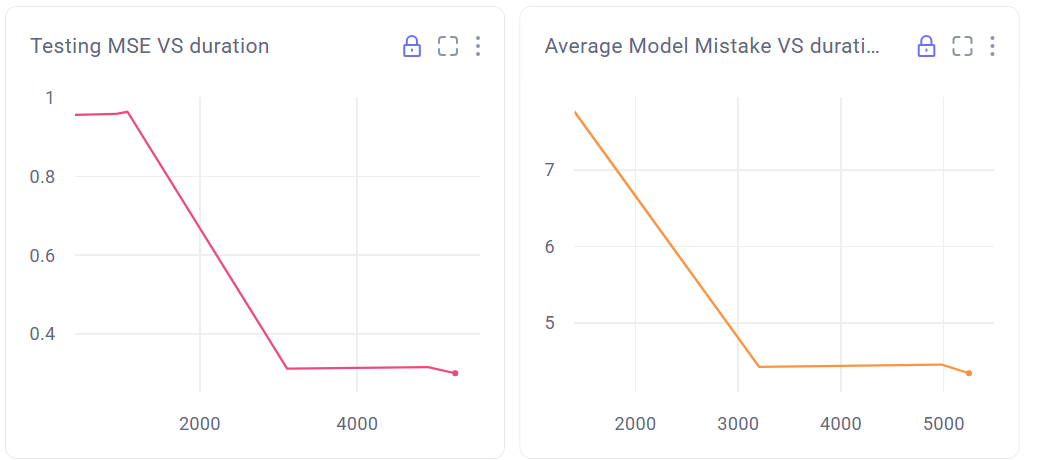

## **Вывод:** 

Лучшие результаты показала модель Catboost с гиперпараметрами  {'learning_rate': 0.26767727312827677, 'depth': 10, 'l2_leaf_reg': 2.320477868945964, 'iterations': 911}. Метрика MSE на тестовой выборке 0.31 - средняя ошибка модели - 4.42 %. Наша модель сможет предсказывать на новых данных с ошибкой в пределах 5 %. Модель можно использовать для предсказания цен на недвижимость.